## Zaawansowane Metody Inteligencji Obliczeniowej
# Zadanie domowe 2
### Prowadzący: Michał Kempka, Marek Wydmuch
### Autor: Ewa Komkowska (136737), zajęcia: czw. 16:50

## Wprowadzenie

Zadania będą polegały na implementacji różnych wariantów algorytmu Q-Learning dla dwóch środowisk z biblioteki OpenAI Gym (https://gym.openai.com): `CartPole` i `LunarLander`.

#### Uwaga: Możesz dowolnie modyfikować elementy tego notebooka (wstawiać komórki i zmieniać kod) o ile nie napisano gdzieś inaczej.

In [171]:
# Zainstaluj bibliotekę OpenAI Gym i PyTorch
!pip install gym torch matplotlib numpy box2d
# W wypadku problemów z działaniem `env.render()` na macOS Big Sur uruchom również poniższą linię
#!pip install pyglet==1.5.15

### Środowisko `CartPole` i `LunarLander`

Poniższy kod demonstruje działanie środowiska `CartPole` (https://gym.openai.com/envs/CartPole-v1) i `LunarLander` (https://gym.openai.com/envs/LunarLander-v2/).

In [172]:
# Zobacz jak działają środowiska na przykładzie 1000 kroków
import gym

env = gym.make("CartPole-v1")
#env = gym.make("LunarLander-v2")
observation = env.reset()
for _ in range(1000):
    # env.render()
    action = env.action_space.sample()
    observation, reward, done, _ = env.step(action)

    if done:
      observation = env.reset()
env.close()

In [173]:
# Zobacz jakim typem są obserwacje (reprezentacja stanu) oraz jaka jest przestrzeń akcji:
print("Przestrzeń stanów:", env.observation_space)
print("Rozmiar wektora reprezntującego stany:", env.observation_space.shape)
print("Ostatnia obserwacja:", type(observation), observation)
print("Przestrzeń akcji:", env.action_space)
print("Ilość możliwych akcji:", env.action_space.n)

Przestrzeń stanów: Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
Rozmiar wektora reprezntującego stany: (4,)
Ostatnia obserwacja: <class 'numpy.ndarray'> [-0.03308349 -0.34993204  0.04751713  0.5871393 ]
Przestrzeń akcji: Discrete(2)
Ilość możliwych akcji: 2


### Interface agenta

Wszystkie implementacje będą w oparciu o klasę `Agent` przedstawioną poniżej. Powinna ona implementować dwie metody: 1) `process_transition`, która będzie wykorzystywana tylko podczas uczenia by przekazać do agenta krotkę zawierającą obserwacje, podjętą akcję, nagrodę i następujący stan oraz informację czy jest on terminalny. 2) `get_action` która na podstawie obserwacji zwraca akcję, dodatkowy argument informuje Agenta czy jest aktualnie podczas uczenia czy ewaluacji.

Poniżej znajdziiesz też funkcję `run_agent_in_env`, która korzysta z opisanego wyżej obiektu agenta w celu jego uczenia lub ewaluacji (podobną będziemy używać my podczas sprawdzania wszych rozwiązań). Możecie ją modyfikować jeśli widzicie taką potrzebę. Dopisaliśmy do tej funkcji rysowanie wykresu nagród z minionych epizodów, który uaktualnia się co ich zadaną liczbę.

In [174]:
class Agent:
    def __init__(self, env):
        self.observation_space = env.observation_space
        self.action_space = env.action_space
    
    def process_transition(self, observation, action, reward, next_observation, done):
        raise NotImplementedError()
        
    def get_action(self, observation, learning):
        raise NotImplementedError()

In [175]:
import matplotlib.pylab as plt
from IPython import display
%matplotlib inline


def plot_rewards(rewards):
    plt.figure(figsize=(14,6))
    plt.plot(rewards)
    display.display(plt.gcf())
    display.clear_output(wait=True)

    
def run_agent_in_env(env, agent, episodes, learning=False, plot=False, plot_interval=1000):
    rewards = []
    for episode in range(episodes):
        observation = env.reset()
        total_reward = 0
        done = False
        while not done :
            # Zapytajmy agenta o akcje dla aktualnego stanu
            action = agent.get_action(observation, learning)
            
            # Wykonajmy akcje
            next_observation, reward, done, _ = env.step(action)
            total_reward += reward
            
            # Jeśli się uczymy, przekażmy przejście do agenta
            if learning:
                agent.process_transition(observation, action, reward, next_observation, done)
            
            observation = next_observation
        rewards.append(total_reward)
        
        # Wyświetl na wykresie nagrody otrzymane po kolei w epizodach
        if plot and episode % plot_interval == 0:
            plot_rewards(rewards)
    return rewards    

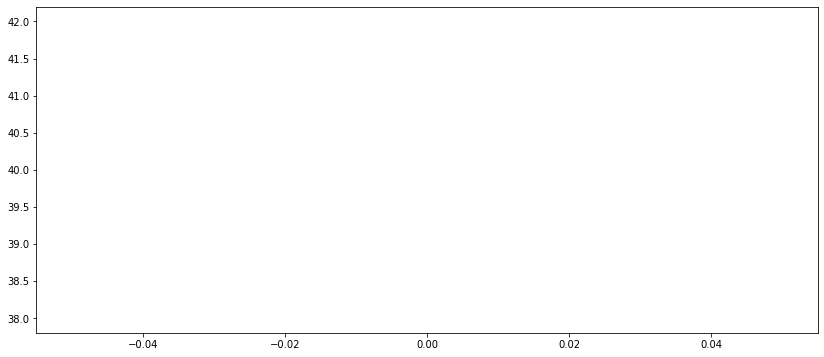

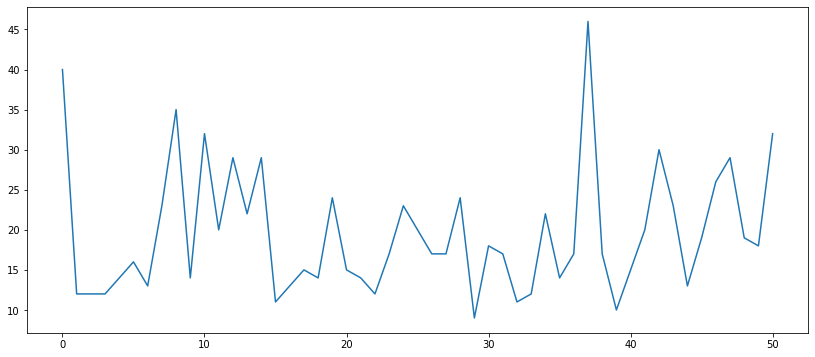

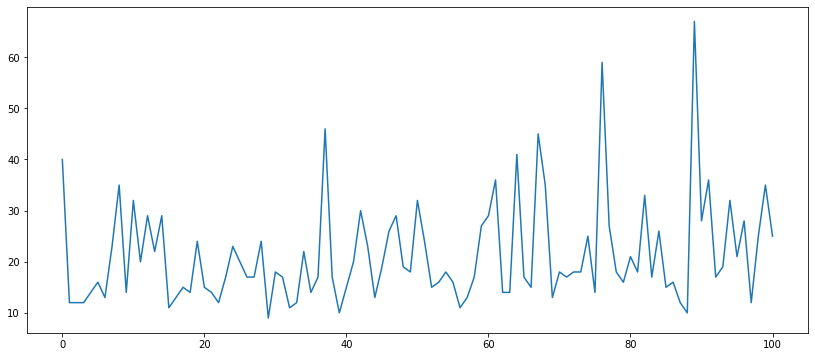

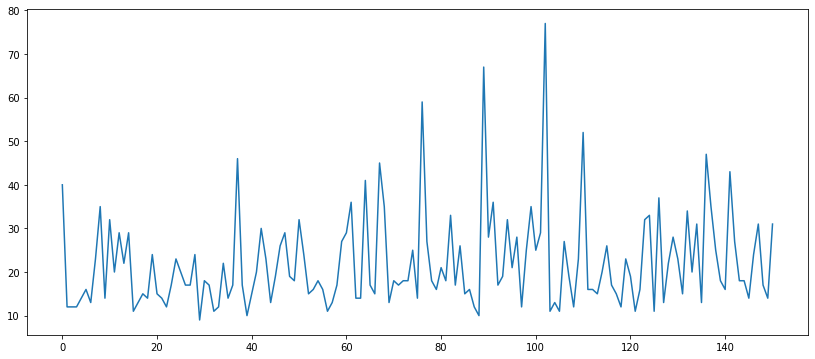

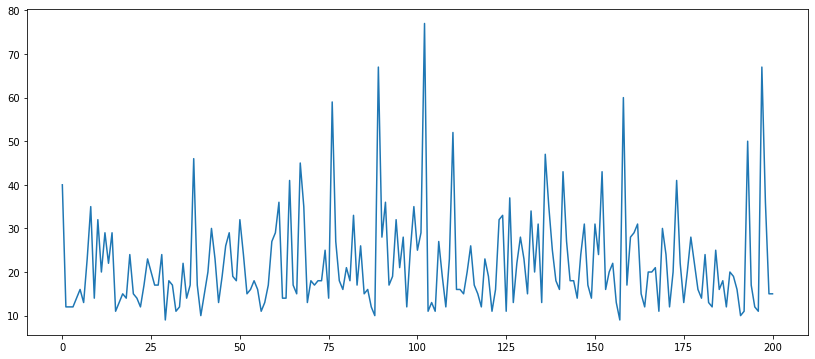

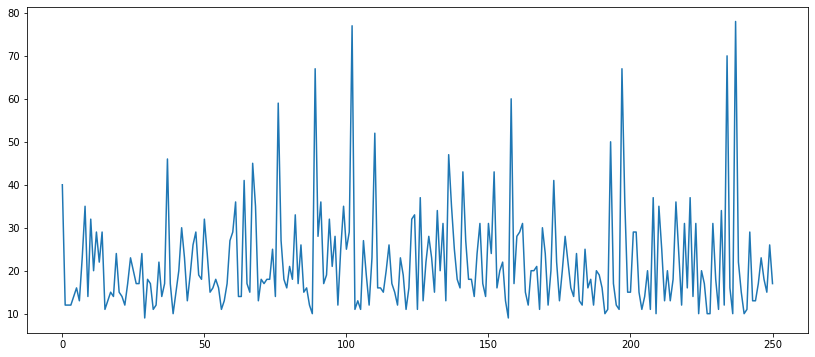

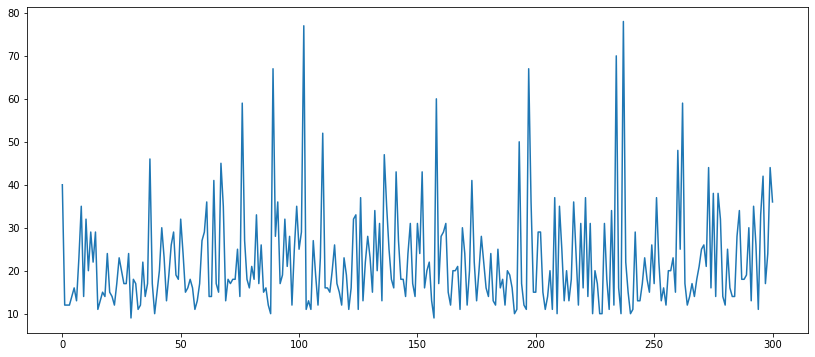

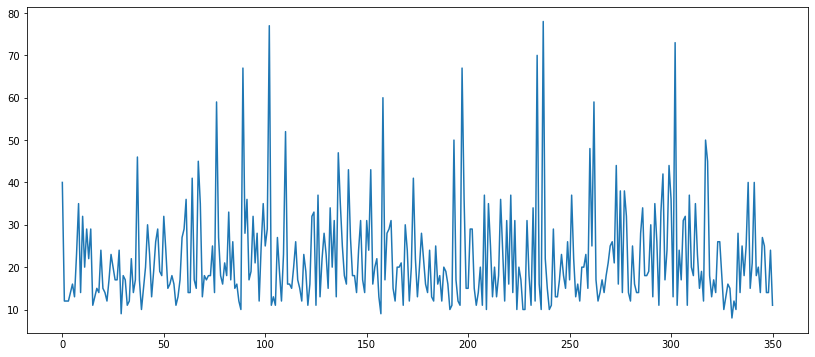

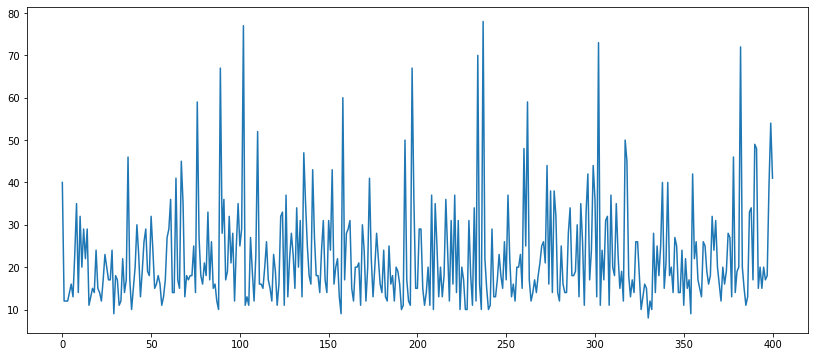

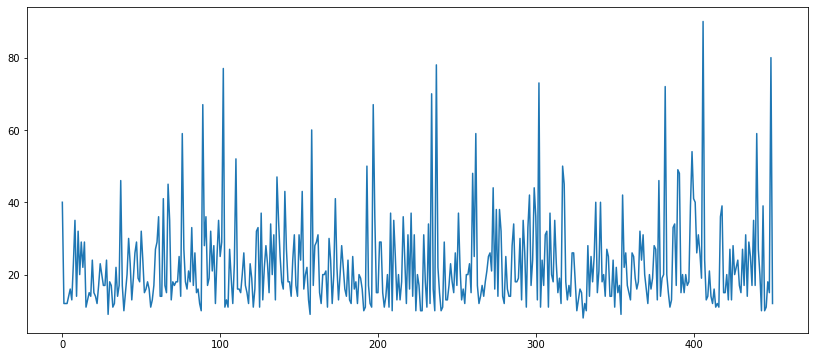

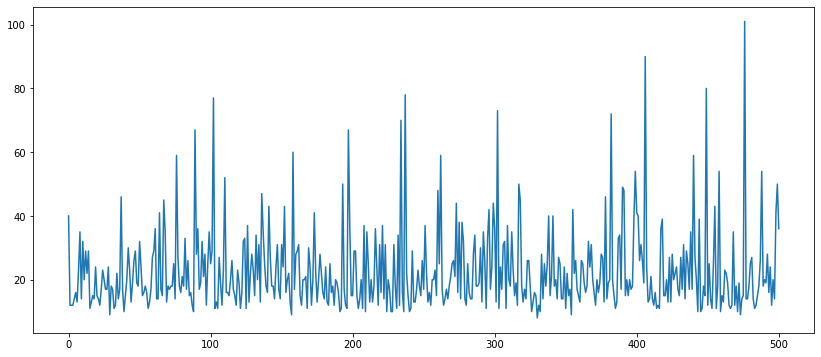

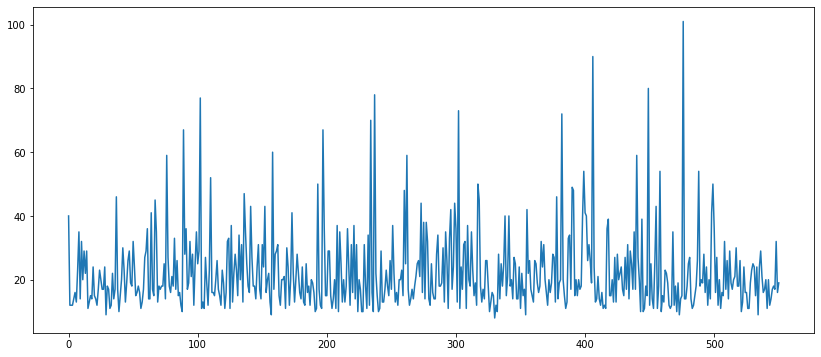

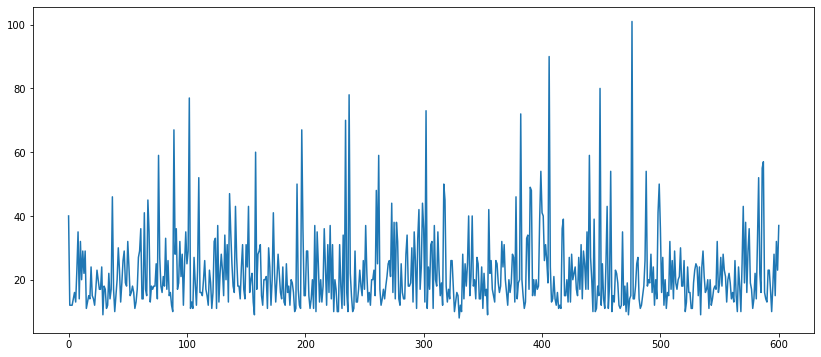

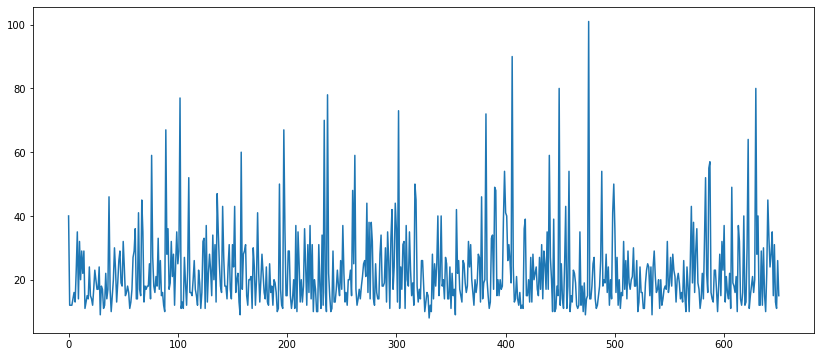

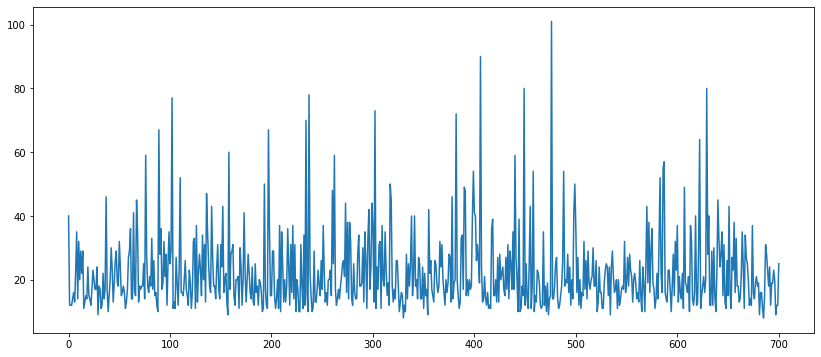

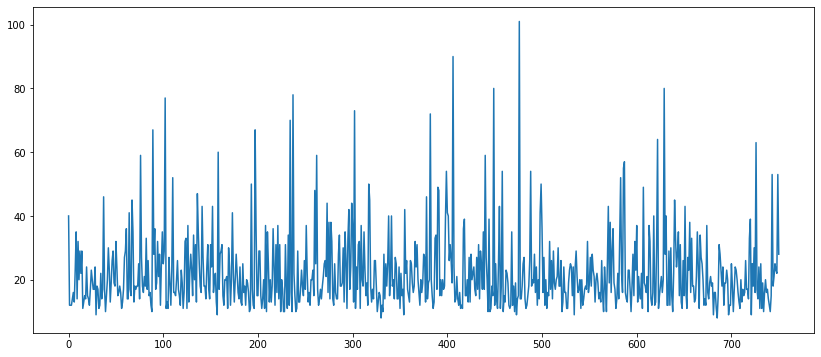

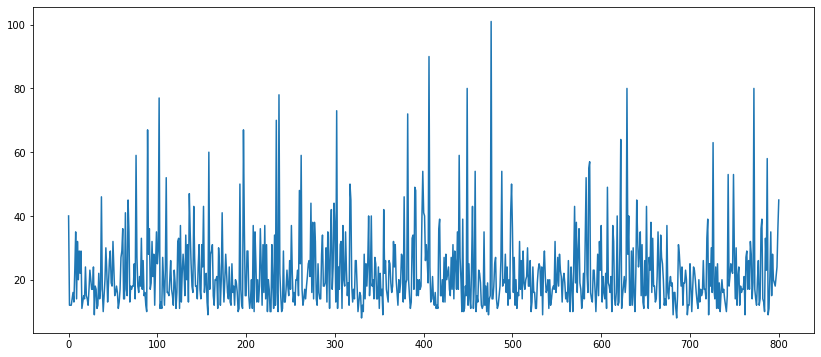

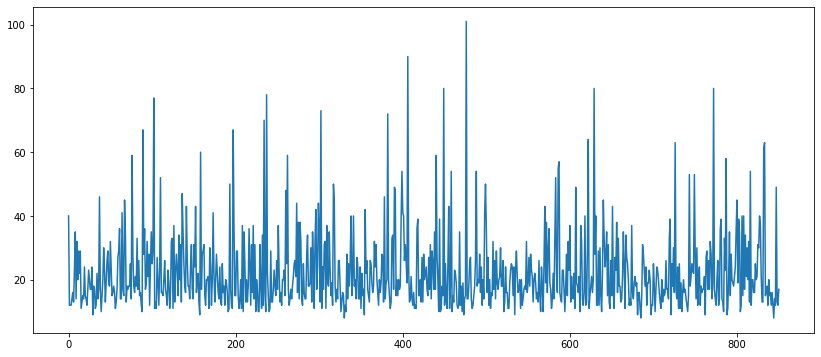

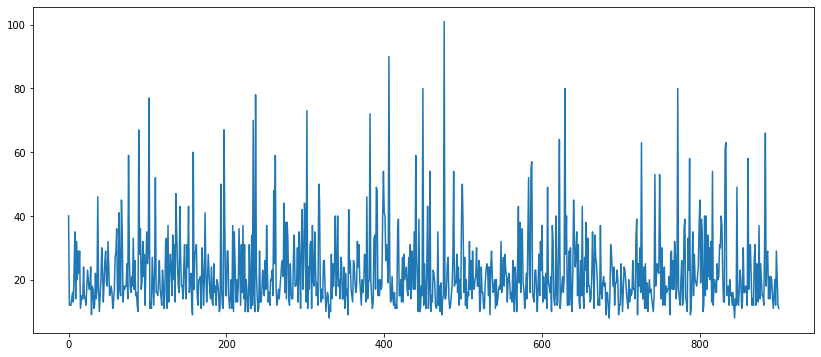

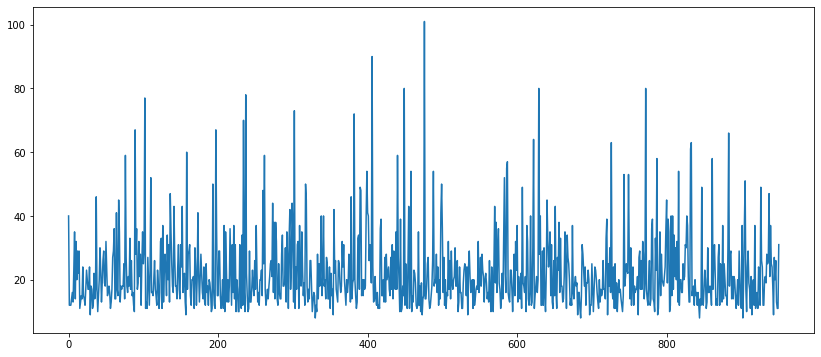

In [176]:
# Demonstracja na przykładzie losowego agenta
env = gym.make("CartPole-v1")

class RandomAgent(Agent):
    def __init__(self, env):
        super().__init__(env)
    
    def process_transition(self, observation, action, reward, next_observation, done):
        pass
        
    def get_action(self, observation, learning):
        return self.action_space.sample()
    
random_agent = RandomAgent(env)
rewards = run_agent_in_env(env, random_agent, 1000, plot=True, plot_interval=50)

## Zad 1 - Tabularyczny Q-Learning (5pkt)

W komórkach poniżej zaimplementuj prosty tabularyczny Q-Learning dla środowiska `CartPole`, korzystający podczas uczenia się z polityki epsilon-greedy. Ponieważ środowisko `CartPole` ma ciągłą przesteń stanów musisz dokonać odpowiedniej dyskretyzacji stanów. 

Odpowiedz na pytanie: dlaczego po osiągnięciu dobrych wyników obserwujemy spadek jakości? Czy możemy temu jakoś zaradzić?

Uwagi:
- Dobra polityka dająca średni wynik powyżej 200, środowisko ma limit na 500 iteracji. Polityka dająca średni wynik blisko 500 jest więc bardzo dobra.
- Uczenie nie powinno trwać więcej niż 10-15 minut na CPU.
- Postaraj się dobrać i ustawić w `__init__` takie parametry by Twój Agent uczył się i działał jak najlepiej. Są one pod Twoją kontrolą w klasie, więc możesz je odpowiednio kontrolować w trakcie uczenia.


#### Uwaga: nie zmieniaj nazwy klasy `TabularQLearningAgent`, ani pozycyjnych (tych bez wartości domyślnych) argumentów jej metod, możesz dopisywać argumenty z wartościami domyślnymi oraz oczywiście pomocnicze meotdy do klasy. Nie dopisuj do komóreki z klasą innego kodu.

Odpowiedzi: 

Taki spadek możemy zaobserwować poprzez wykorzystywaną politykę epsilon-greedy i losowy wybór stanów podczas uczenia. Możemy temu zaradzić poprzez lepsze dobranie parametrów takich jak epsilon, czy epsilon_decay_value, jednak praktycznie może okazać się to trudne. Możemy też spróbować skrócić uczenie agenta (poprzez zmniejszenie epizodów), aby nie nadpisywał stanów, które były dobre, jednak to może często spowodować popadanie np. w optima lokalne, albo okazać się nieefektywne dla innego środowiska. 
Dodatkowo może to być też spowodowane dyskretyzacją stanów (a także doborem jej parametrów). Polega ona na podzieleniu stanów na pewne przedziały, co może spowodować, że algorytm trafi akurat na te części danego przedziału, dzięki którym osiąga wysokie wyniki, a czasem może zdarzyć się tak, że akurat dana akcja dla rzeczywistych wartości przyniesie spory spadek. Można temu trochę zapobiec także zmniejszając ilość eksploracji z kolejnymi etapami uczenia, dzięki czemu algorytm "skupi się bardziej" na stanach już odwiedzonych i dopracuje ich politykę. 

In [ ]:
class TabularQLearningAgent(Agent):
    def __init__(self, env, epsilon = 0.99, min_epsilon = 0.1, epsilon_decay_value = 0.9995, learning_rate = 0.1, discout_factor = 0.95, discrete_number = 100):
        super().__init__(env)
        # Zainicjalizuj tutaj swojego agenta

        self.epsilon = epsilon
        self.min_epsilon = min_epsilon
        self.epsilon_decay_value = epsilon_decay_value

        self.learning_rate = learning_rate
        self.discout_factor = discout_factor
        self.iteration = 0

        # DYSKRETYZAJCA STANÓW
        discrete_space_size = [discrete_number] * len(self.observation_space.sample())
        self.q_table = np.zeros((discrete_space_size + [env.action_space.n]))

    
    def process_transition(self, observation, action, reward, next_observation, done):
        # Miejsce na Twoją implementację
        discrete_state = self.get_discrete_state(observation)
        new_discrete_state = self.get_discrete_state(next_observation)

        if not done:
          current_q = self.q_table[discrete_state + (action, )]
          new_q = current_q - self.learning_rate * (current_q - (reward + self.discout_factor * np.max(self.q_table[new_discrete_state])))
          self.q_table[discrete_state + (action, )] = new_q

        else:
          self.q_table[discrete_state + (action, )] = 0
        
        self.iteration += 1

        if self.epsilon > self.min_epsilon and self.iteration % 20 == 0:
          self.epsilon = max(self.min_epsilon, self.epsilon_decay_value * self.epsilon)

        
    def get_action(self, observation, learning):
        # Miejsce na Twoją implementację
        discrete_state = self.get_discrete_state(observation)
        if not learning or np.random.random() > self.epsilon:
          action = np.argmax(self.q_table[discrete_state])
        
        else:
          action = np.random.randint(0, self.action_space.n)

        return action

    def get_discrete_state(self, state):
        discrete_state = state/np.array([0.25, 0.25, 0.01, 0.1]) + np.array([15,10,1,10])
        return tuple(discrete_state.astype(np.int))


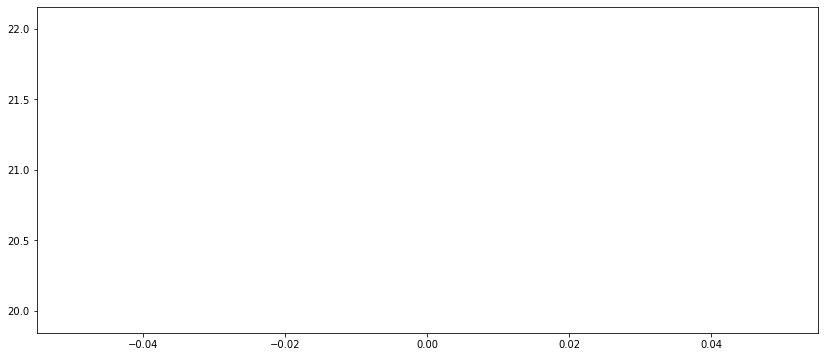

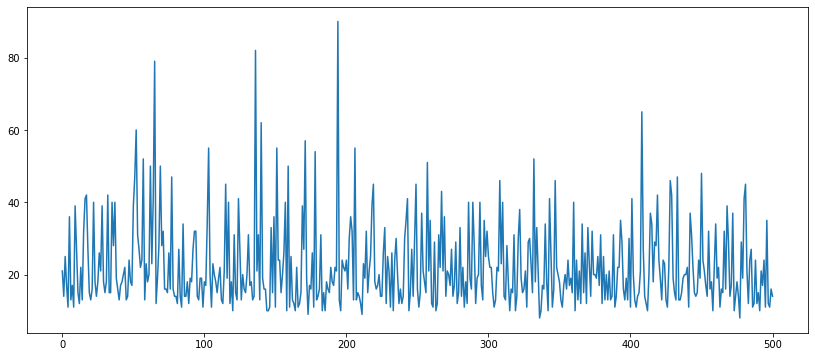

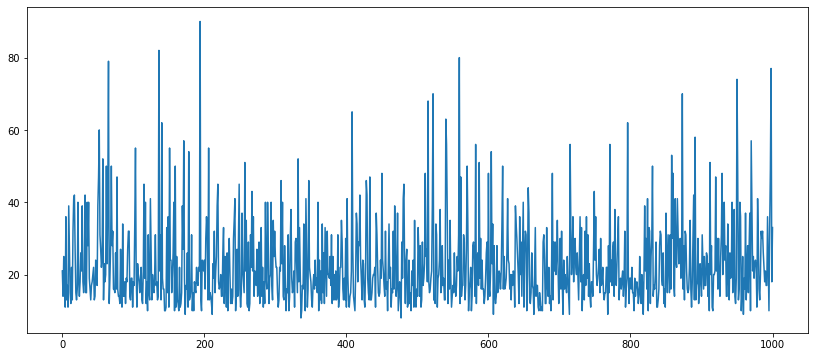

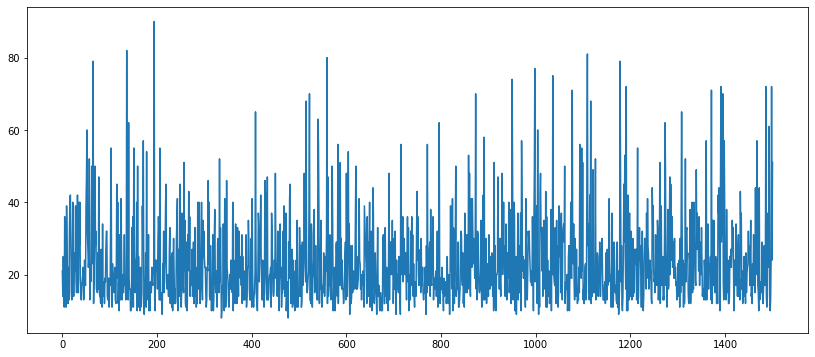

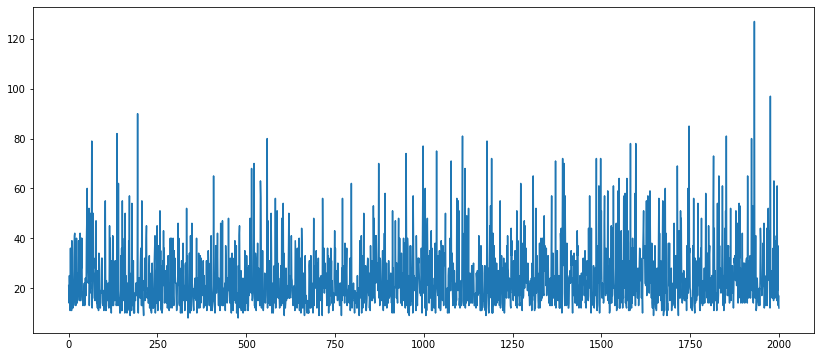

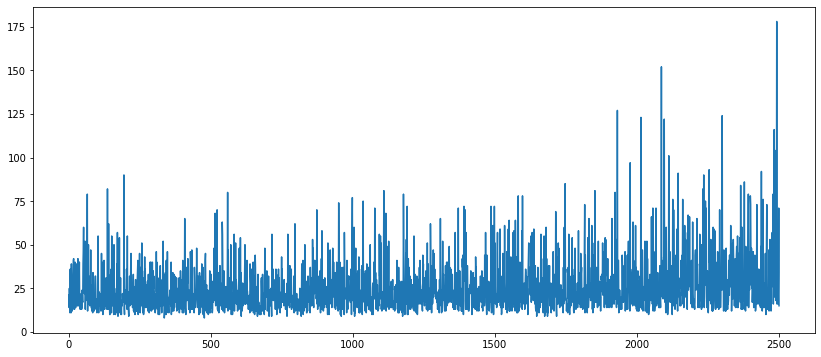

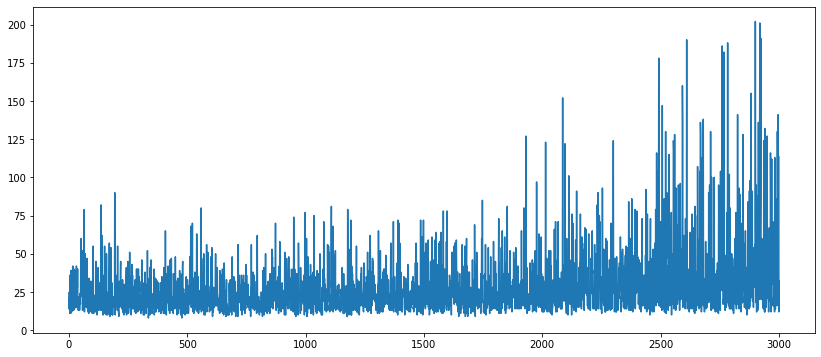

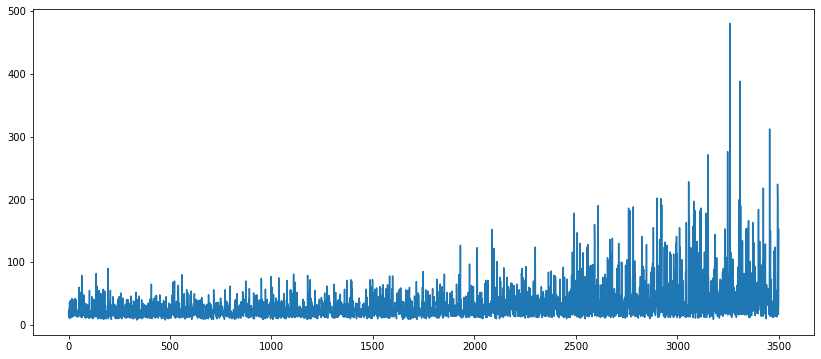

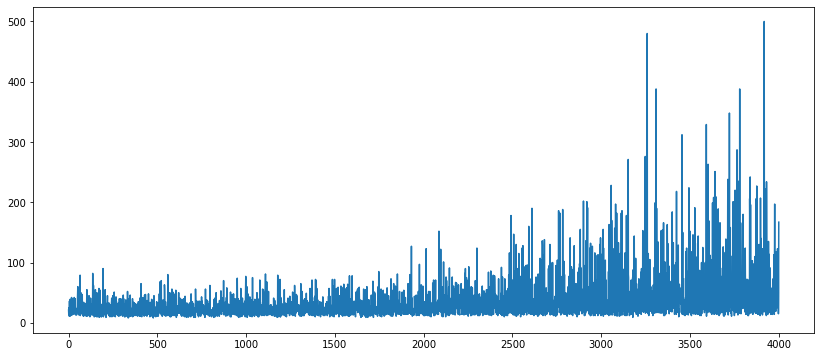

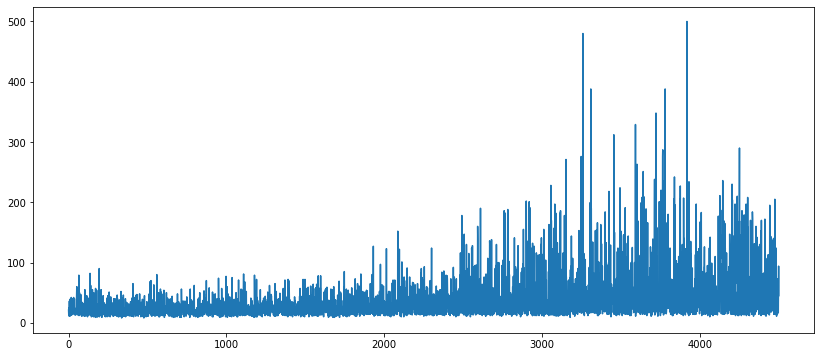

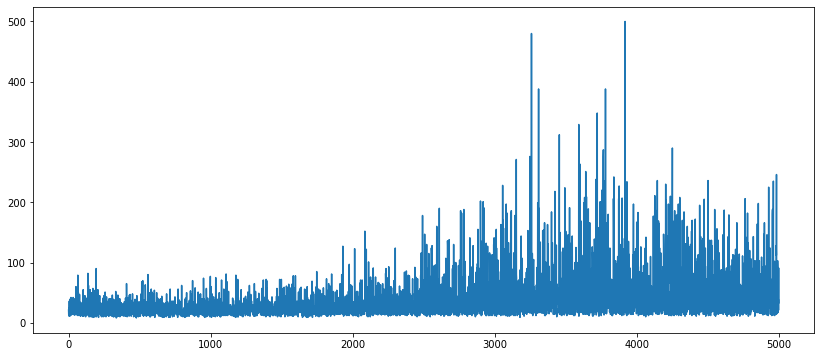

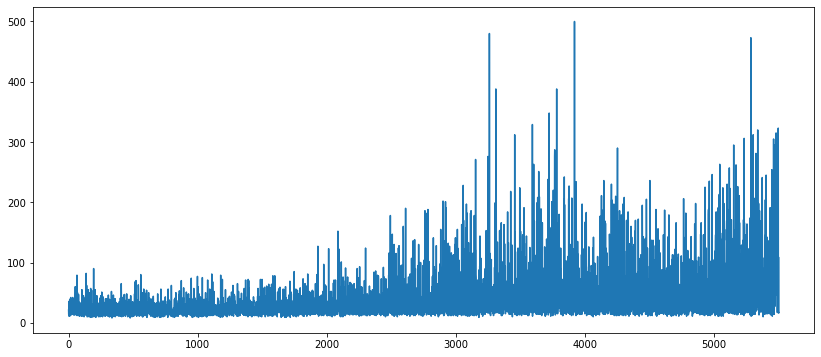

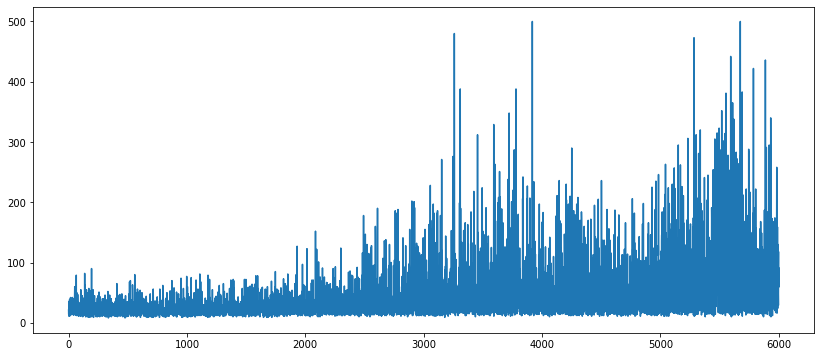

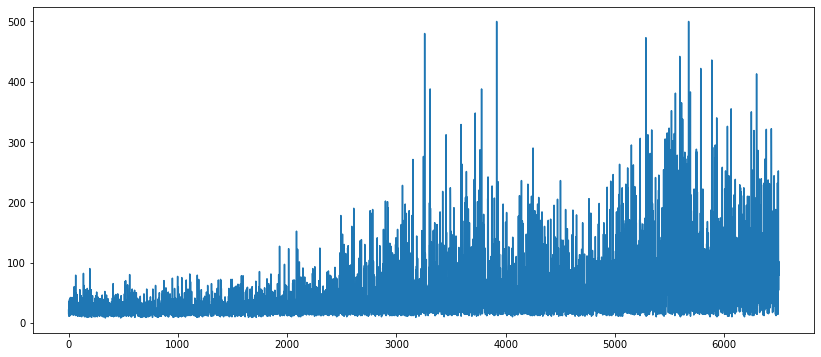

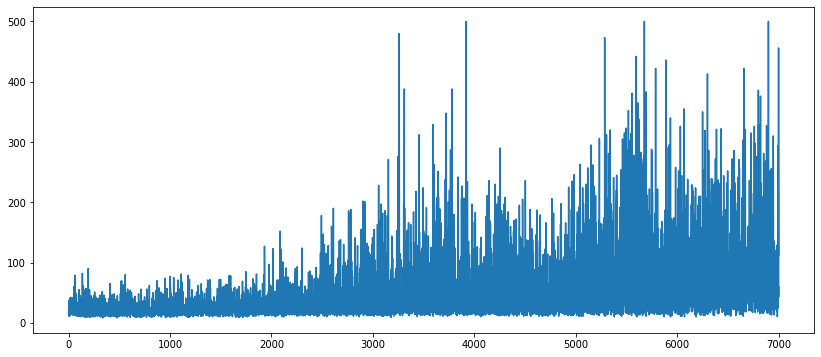

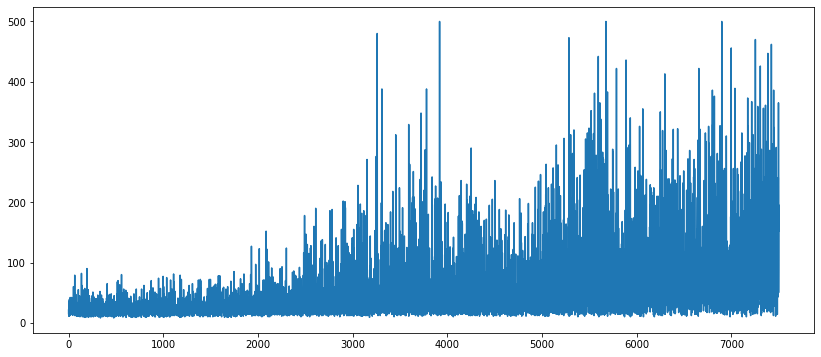

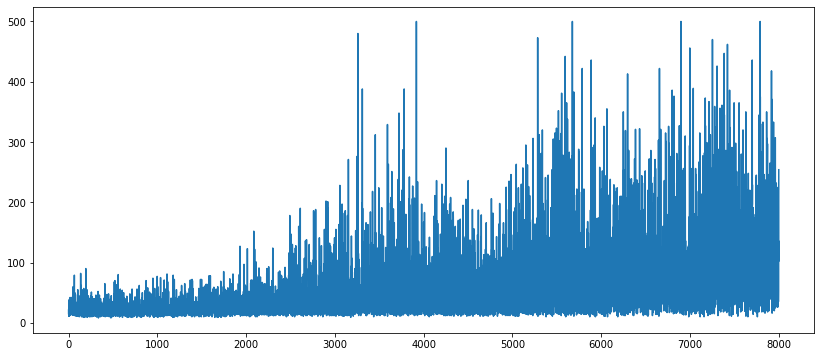

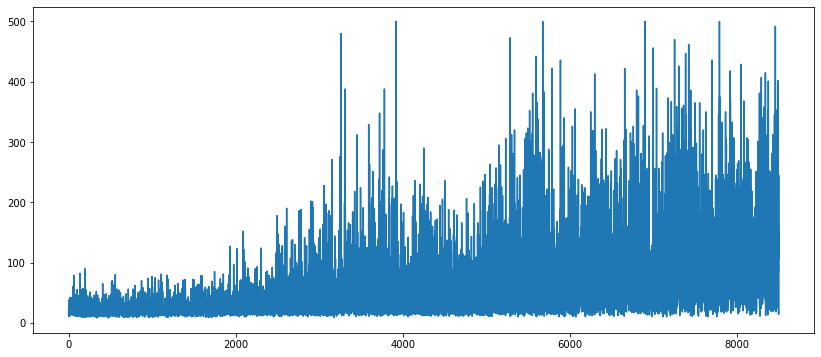

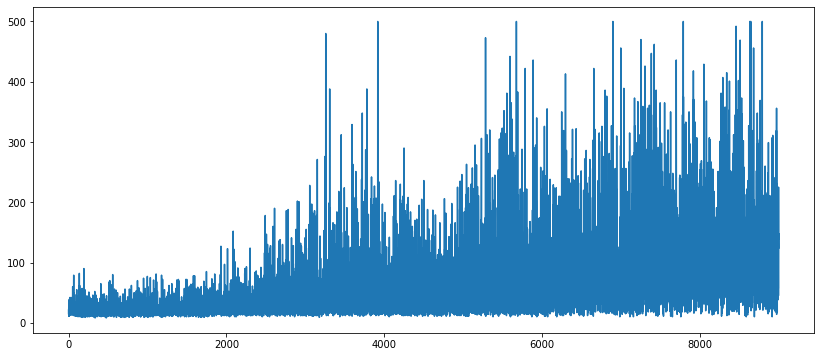

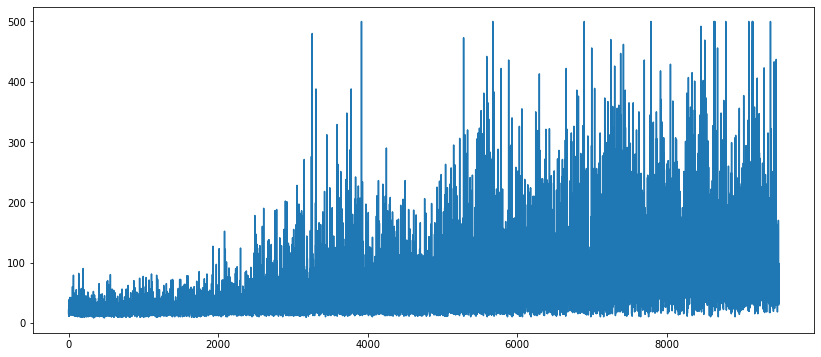

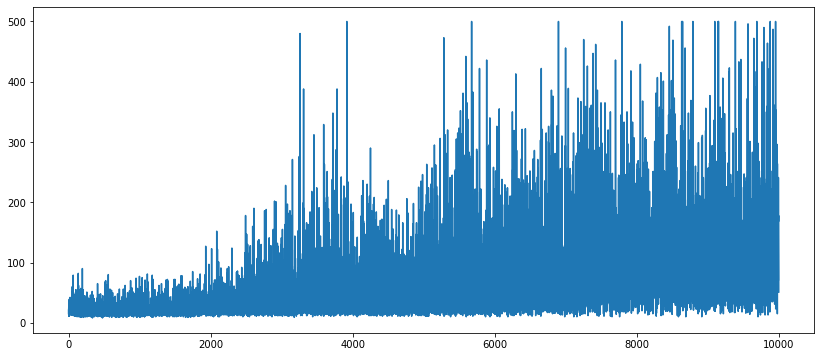

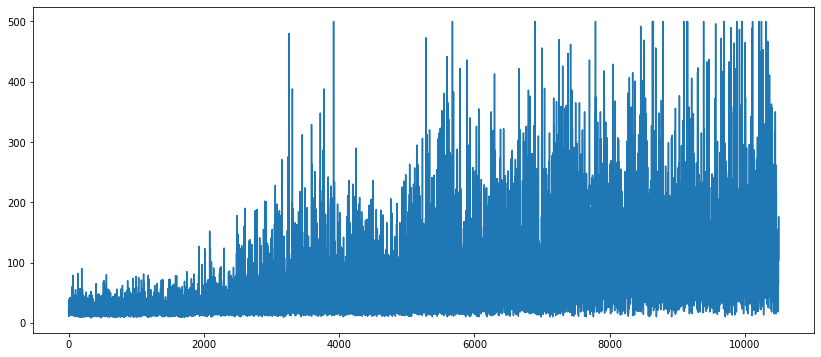

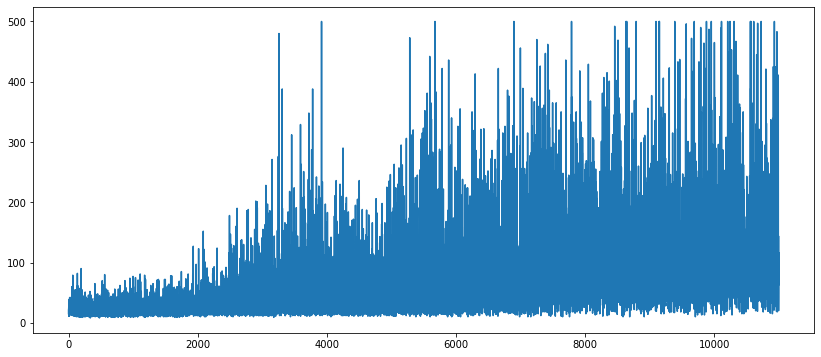

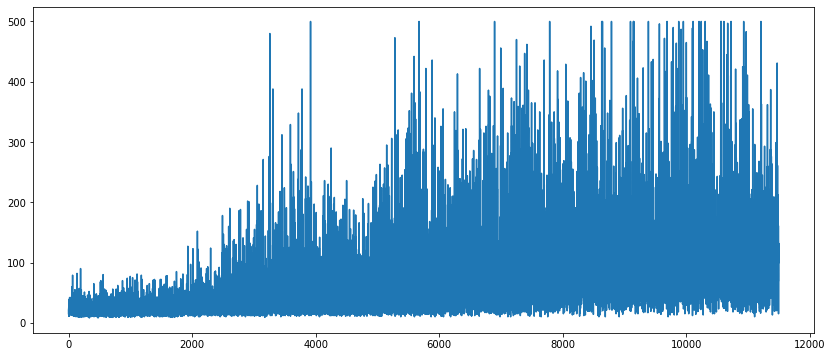

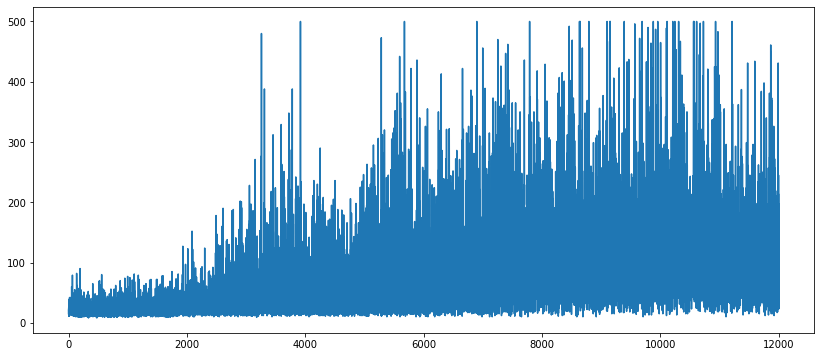

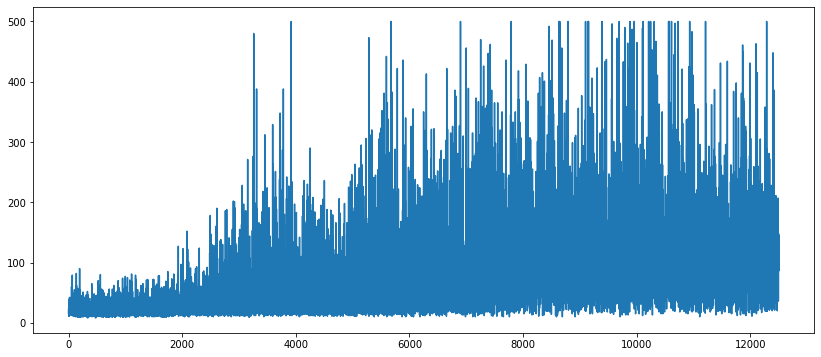

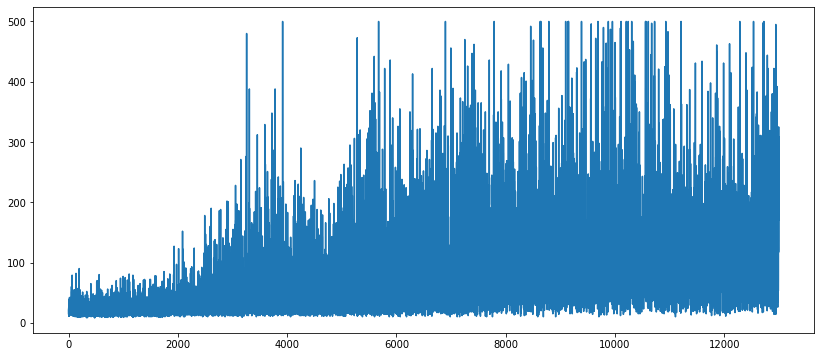

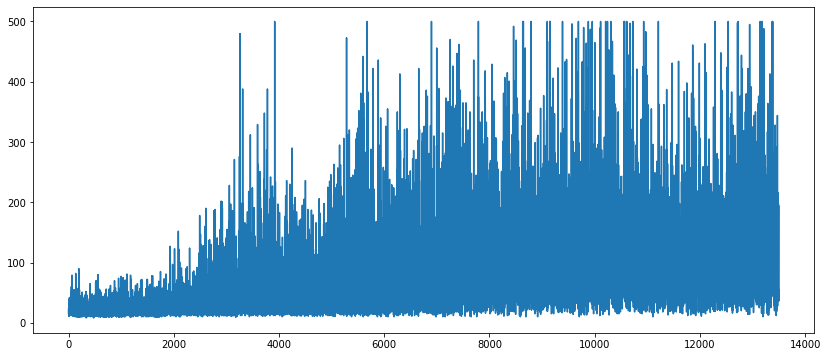

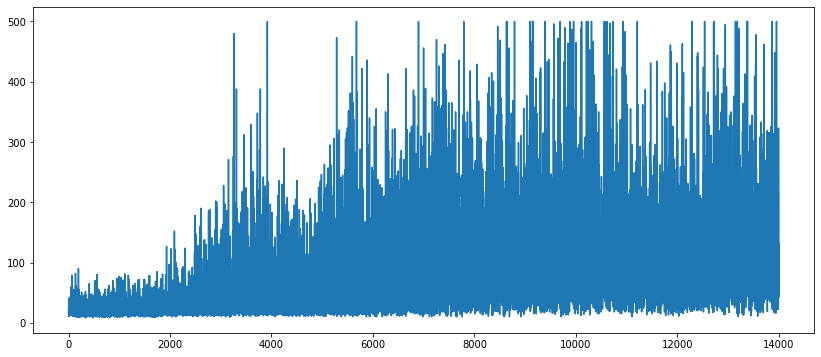

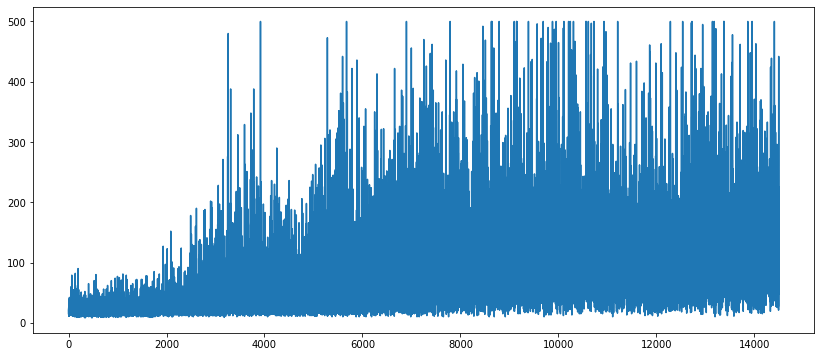

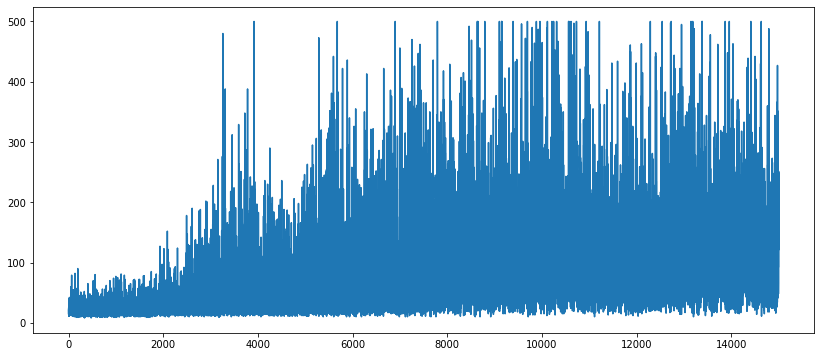

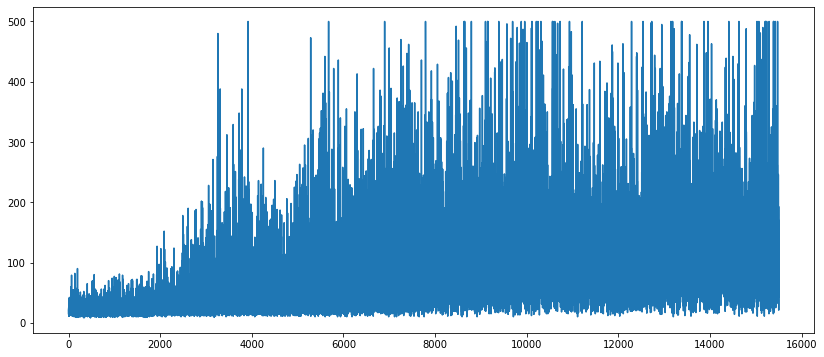

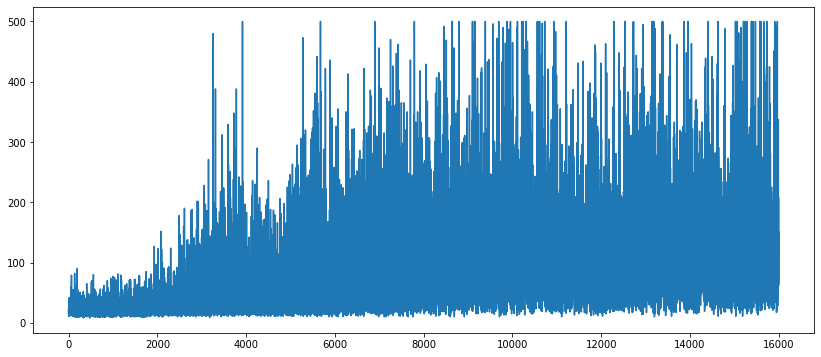

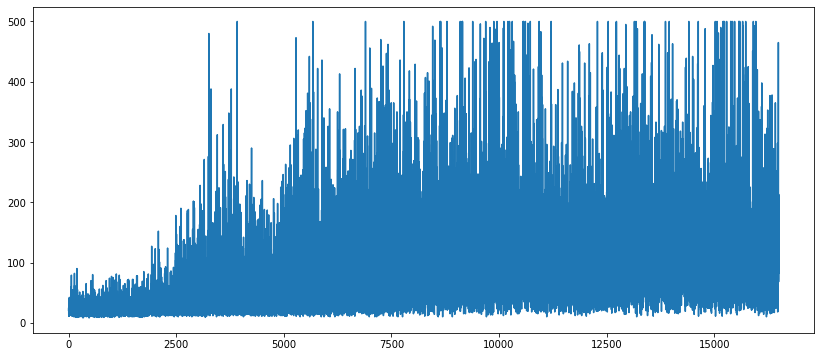

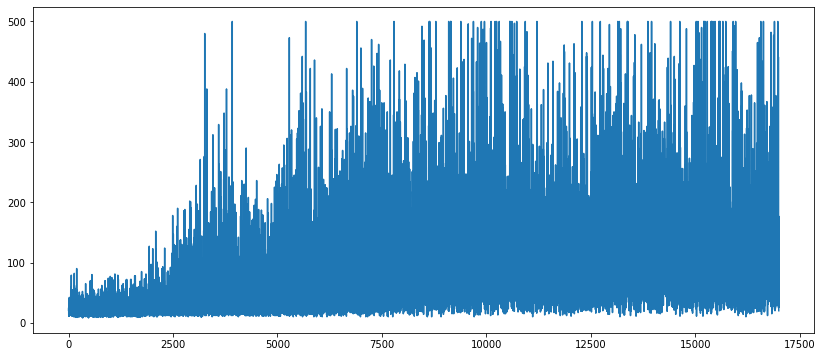

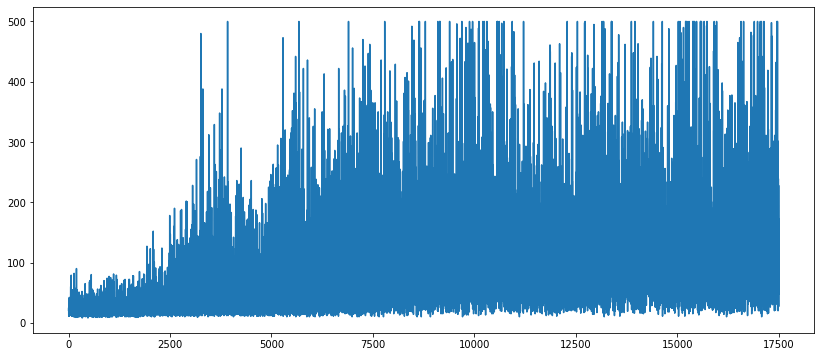

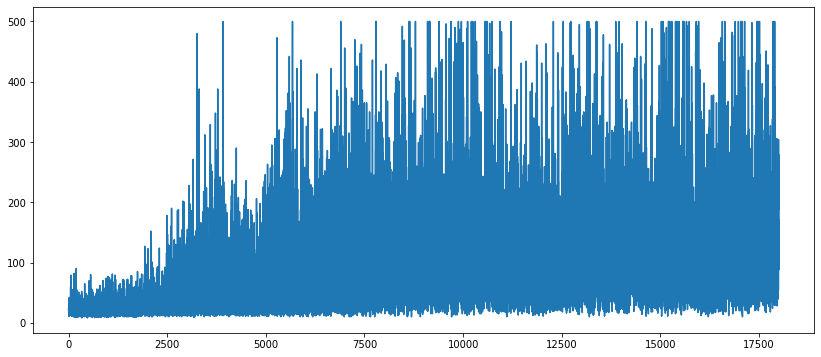

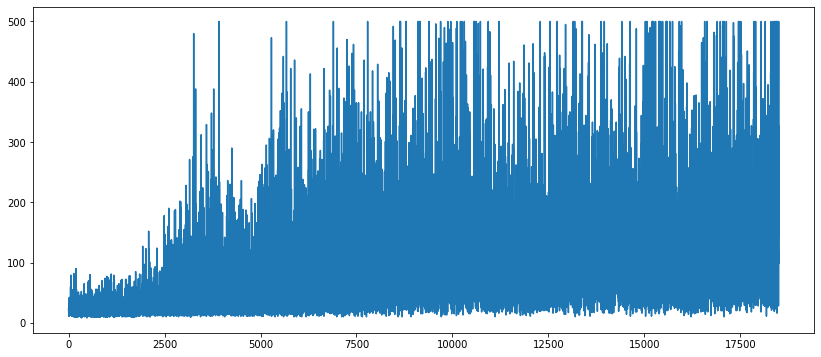

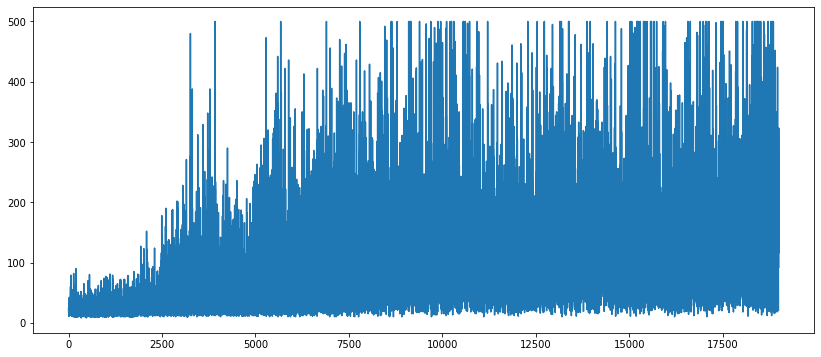

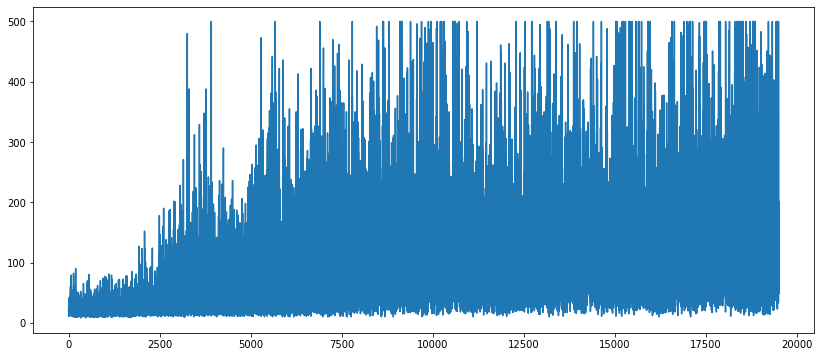

In [ ]:
# Uczenie/testowania agenta
import numpy as np

env = gym.make("CartPole-v1")
agent = TabularQLearningAgent(env)
rewards = run_agent_in_env(env, agent, 20000, learning=True, plot=True, plot_interval=500)

In [ ]:
print(np.min(rewards))
print(np.max(rewards))
print(np.mean(rewards))

8.0
500.0
104.3607


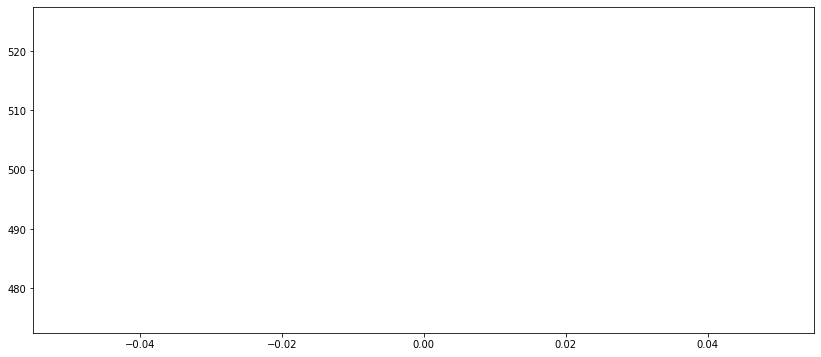

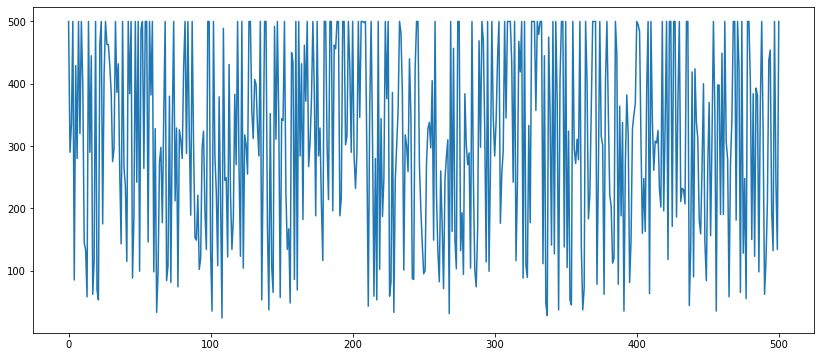

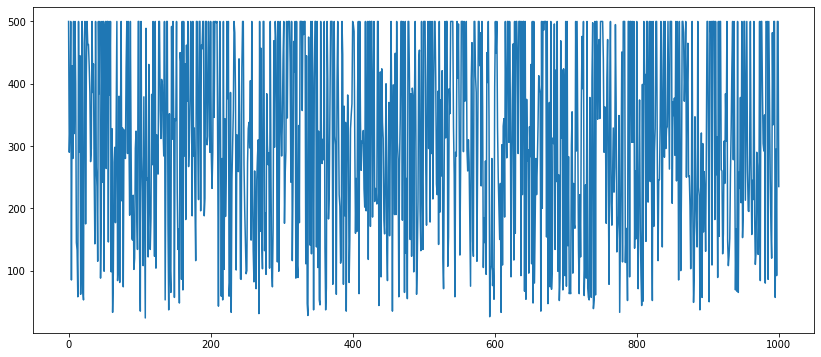

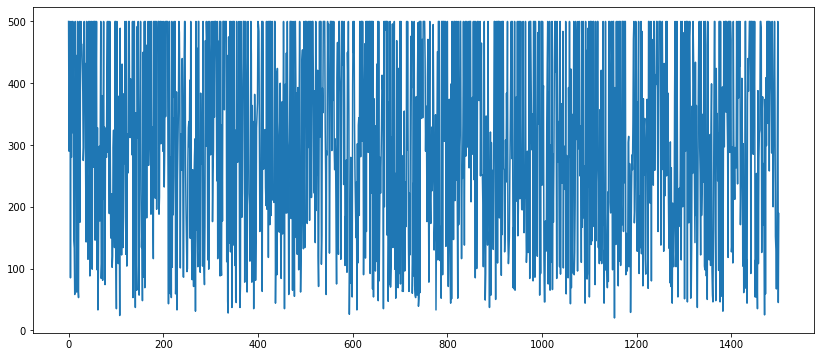

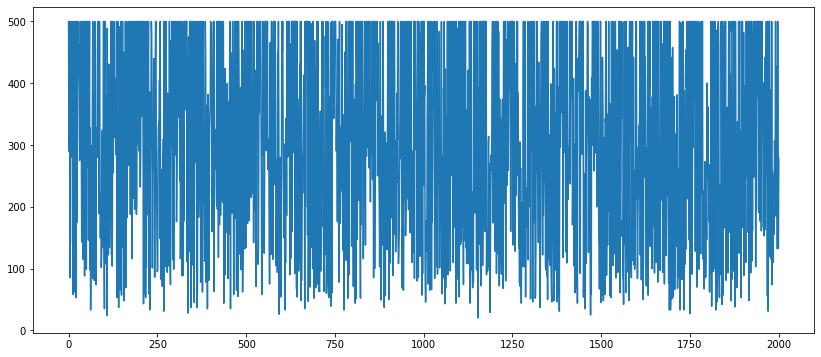

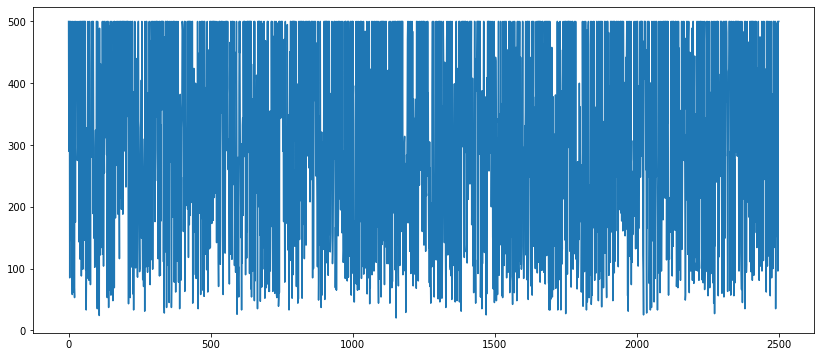

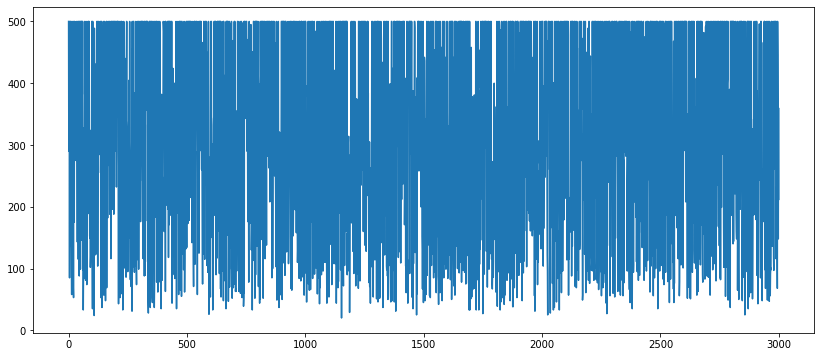

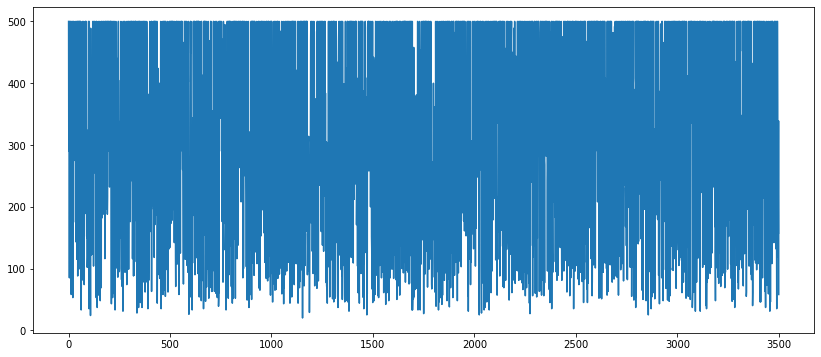

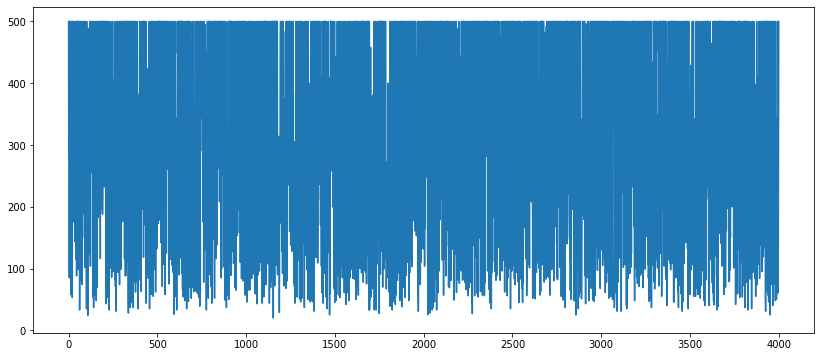

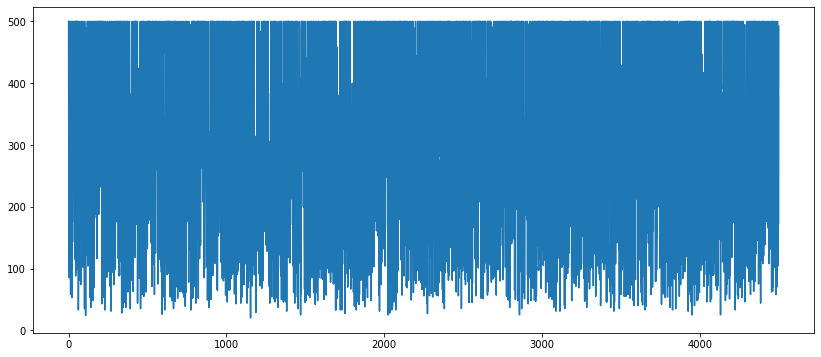

In [ ]:
new_rewards = run_agent_in_env(env, agent, 5000, learning=False, plot=True, plot_interval=500)

In [ ]:
print(np.min(new_rewards))
print(np.max(new_rewards))
print(np.mean(new_rewards))

20.0
500.0
302.2674


## Zad 2 - Q-Learning z aproksymacją (25pkt)

W komórkach poniżej zaimplementuj Q-Learning z aproksymacją dla środowiska `LunarLander`, korzystający podczas uczenia się z polityki epsilon-greedy, a jako aproksymatora użyj prostej sieci neuronowej zaimplementowanej z wykorzystaniem biblioteki PyTroch. Zaimplementuj następujące ulepszenia algorytmu Q-Learning:
- replay memory i uczenia batchowe zamiast uczenia online
- network freezing
- double q-learning

Porównaj ze sobą różne warianty algorytmu (nie duplikuj swojej implementacji, dodaj odpowiednie argumenty w konstruktorze, które będą włączać/wyłączać odpowiednie rozszerzenie), zademonstruj oczywiście swoje wyniki pozostawiając odpowiedni output z komórek oraz je skomentuj. Opisz również jak dokonałeś doboru parametrów Twojego modelu.

Uwagi:
- Dobra polityka powina mieć średnią bliską 100, bardzo dobra bliską 200.
- Uczenie nie powinno trwać więcej niż 10-15 minut (przy dobrze zaimplementowanych rozszerzeniach powinno być dużo szybsze) na CPU (możesz oczywiście użyć GPU jeśli masz taką możliwość, ale zadbaj by domyślnie Twoja implemnetacja działałą na CPU).
- Postaraj się dobrać i ustawić w `__init__` takie parametry (w tym architektuę sieci neuronowej) by Twój Agent uczył się i działał jak najlepiej. Są one pod Twoją kontrolą w klasie, więc możesz je odpowiednio kontrolować w trakcie uczenia.
- Złożona architektura nie jest potrzebna do rozwiązania tego problemu, zacznij od prostego aproksymatora (np. liniowego albo sieci z dwoma warstwami) i stopniowo zwiększaj jego złożoność.
- Możesz najpierw testować swoją implementację na środowisku `CartPole`, jest to prostszy problem i z dobrymi parametrami nawet prosta wersja Q-Learningu z aproksymacją powinna się go uczyć w nie więcej niż 2-3 minuty na CPU.

#### Uwaga: nie zmieniaj nazwy klasy `NeuralQLearningAgent`, ani pozycyjnych (tych bez wartości domyślnych) argumentów jej metod, możesz dopisywać argumenty z wartościami domyślnymi oraz oczywiście pomocnicze meotdy do klasy. Nie dopisuj do komórki z klasą innego kodu.

**Odpowiedzi:** 

Testy zostały wykonane w następujących kierunkach:
- bez dodatkowej wartstwy (sieć neuronowa miała tylko jedną warstwę ukrytą)
- optimizer: Adagrad, Adam i AdamW 
- loss function: MSELoss i PoissonNLLLoss
- zmiana wartości epsilon, learning_rate

***Dobór parametrów:*** 

W ramach doboru parametrów przprowadziłam eksperymenty na różnych wartościach. Testowałam głównie architekturę sieci neuronowej, wartość learning_rate i epsilon. Sprawdzałam następnie minimalne, średnie i maksymalne wartości dla nauczonego już agenta starając się uzyskiwać jak najwyższą wartość średniej nagrody.
Na przedstawionych poniżej testach widać także, że optimizer Adam w połączeniu z funkcją MSELoss() nie spełnia swojego zadania - wyniki dla podstawowej wersji algorytmu są zaniżone. Podobnie inne wartości epsilon (zarówno mniejsza jak i większa) oraz learning_rate. 

***Porównanie wariantów:***

Widać, że wariant z uczeniem batchowym minimalnie lepiej wypada podczas testów w porównaniu z domyślnym uczeniem, dodatkowo czas jego wykonywania jest krótszy. Na wykresie widać także mniejszy spadek początkowych wartości - agent miał więcej przykładów, z którymi dobrze sobie poradził i dzięki temu szybciej uzyskiwał wyższe wartości. Warianty network_freezing i DDQL osiągnęły bardzo słabe rezultaty, więc prawdopodobnie pokawił się błąd w ich implemnetacji. Nie uzyskały bowiem one nawet wartości maksymalnych > 0. Ich celem jest uzyskiwanie mniej optymistycznych wyników, jednak przedstawione poniżej wydają się być za bardzo pesymistyczne. Dodatkowo wykorzystują one mechanizm pamięci, który zawiera także pierwsze rozszerzenie. 

In [177]:
import torch as T
import torch.nn.functional as F
import torch.optim as optim

class LearningModel(T.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output, n_hidden_2, learning_rate):
        super(LearningModel, self).__init__()
        self.n_feature = n_feature 
        self.n_hidden = n_hidden
        self.n_hidden_2 = n_hidden_2
        self.n_output = n_output

        self.fc1 = T.nn.Linear(*self.n_feature, self.n_hidden)
        self.fc2 = T.nn.Linear(self.n_hidden, self.n_hidden_2)
        self.fc3 = T.nn.Linear(self.n_hidden_2, self.n_output)

        self.optimizer = optim.AdamW(self.parameters(), lr=learning_rate) # Adagrad
        self.loss = T.nn.PoissonNLLLoss() #MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        x = F.relu(self.fc1(state))    
        x = F.relu(self.fc2(x))     
        actions = self.fc3(x)             

        return actions

In [178]:
class NeuralQLearningAgent(Agent):
    def __init__(self, env, states_number=[8], action_numbers=4, hidden_size = 256, iteration_step=20, epsilon = 0.99, min_epsilon = 0.1, epsilon_decay_value = 0.9995, learning_rate = 0.225, discount_factor = 0.99, batch_learning=False, batch_size=200, batch_memory=50, network_freezing=False, double_learning=False, network_update=100):
        super().__init__(env)
        # Zainicjalizuj tutaj swojego agenta
    
        self.epsilon = epsilon
        self.min_epsilon = min_epsilon
        self.epsilon_decay_value = epsilon_decay_value

        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.iteration = 0
        self.iteration_step = iteration_step

        self.batch_learning = batch_learning
        self.batch_size = batch_size
        self.batch_memory = batch_memory
        self.batch_table = np.empty(batch_size, dtype=object)

        self.double_learning = double_learning
        self.network_update = network_update

        self.network_freezing = network_freezing

        self.model = LearningModel(n_feature=states_number, n_hidden=hidden_size, n_hidden_2=hidden_size, n_output=action_numbers, learning_rate=learning_rate)
        self.model_2 = LearningModel(n_feature=states_number, n_hidden=hidden_size, n_hidden_2=hidden_size, n_output=action_numbers, learning_rate=learning_rate)

    
    def process_transition(self, observation, action, reward, next_observation, done):
        # Miejsce na Twoją implementację

        if self.batch_learning or self.double_learning or self.network_freezing: 
          self.batch_table[self.iteration % self.batch_size] = np.array([observation, reward, next_observation])

          if self.iteration != 0 and self.iteration % self.batch_size == 0:
            for i in range(0, self.batch_memory):
              observation, reward, next_observation = self.batch_table[np.random.randint(0, self.batch_size)]

              if not self.double_learning and not self.network_freezing:
                self.learn_model(observation, reward, next_observation)
                self.model.optimizer.step()
              else:
                self.learn_model(observation, reward, next_observation, True)

            if self.iteration != 0 and self.double_learning and self.iteration % self.network_update:
              self.model.optimizer.step()

            elif self.iteration != 0 and self.network_freezing:
              self.model.optimizer.step()

        else:
          self.learn_model(observation, reward, next_observation)  
          self.model.optimizer.step()       

        if self.epsilon > self.min_epsilon and self.iteration != 0:
          self.epsilon = max(self.min_epsilon, self.epsilon_decay_value * self.epsilon)
        
        self.iteration += 1
        
    def get_action(self, observation, learning):
        # Miejsce na Twoją implementację
        if not learning or np.random.random() > self.epsilon:
          state = T.tensor([observation]).to(self.model.device)
          actions = self.model.forward(state)
          action = T.argmax(actions).item()
        
        else:
          action = np.random.randint(0, self.action_space.n)

        return action

    def learn_model(self, observation, reward, next_observation, double_learning=False):
        self.model.optimizer.zero_grad()

        state = T.tensor([observation]).to(self.model.device)
        q_value = self.model.forward(state)

        if not done:
          if double_learning:
            next_state = T.tensor([next_observation]).to(self.model.device)
            q_next = self.model_2.forward(next_state)
          else:
            next_state = T.tensor([next_observation]).to(self.model.device)
            q_next = self.model.forward(next_state)
          
          target = reward + self.discount_factor * T.max(q_next, dim=1)[0]

        else:
          target = reward + self.discount_factor * T.tensor([0])

        loss = self.model.loss(target, q_value).to(self.model.device)
        loss.backward()


#### Testy podstawowej wersji

##### Bez dodatkowej warstwy

In [163]:
import torch as T
import torch.nn.functional as F
import torch.optim as optim

class LearningModel(T.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output, learning_rate):
        super(LearningModel, self).__init__()
        self.n_feature = n_feature 
        self.n_hidden = n_hidden
        self.n_output = n_output

        self.fc1 = T.nn.Linear(*self.n_feature, self.n_hidden)
        self.fc3 = T.nn.Linear(self.n_hidden, self.n_output)

        self.optimizer = optim.AdamW(self.parameters(), lr=learning_rate) # Adagrad
        self.loss = T.nn.PoissonNLLLoss() #MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        x = F.relu(self.fc1(state))      
        actions = self.fc3(x)             

        return actions

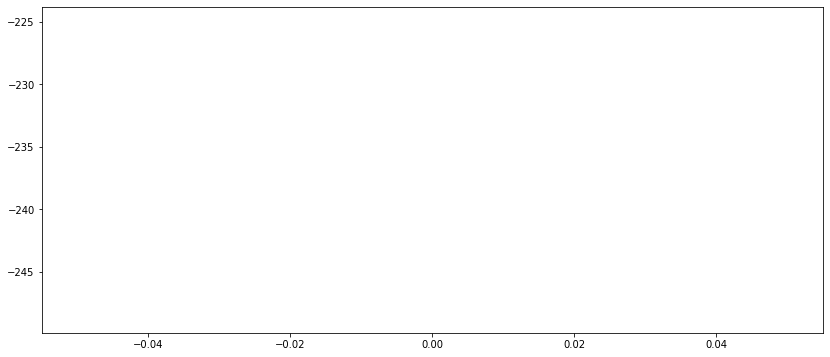

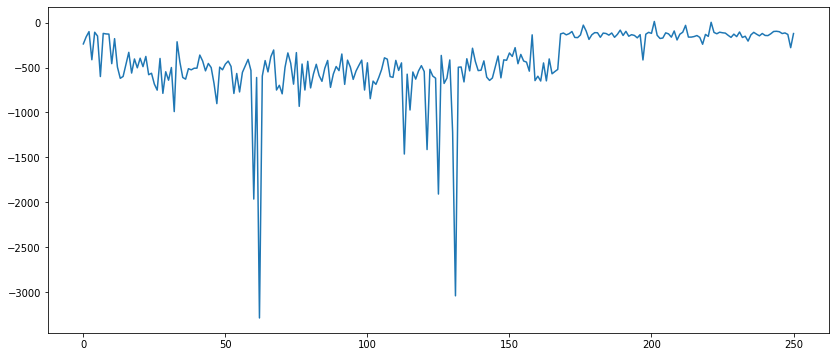

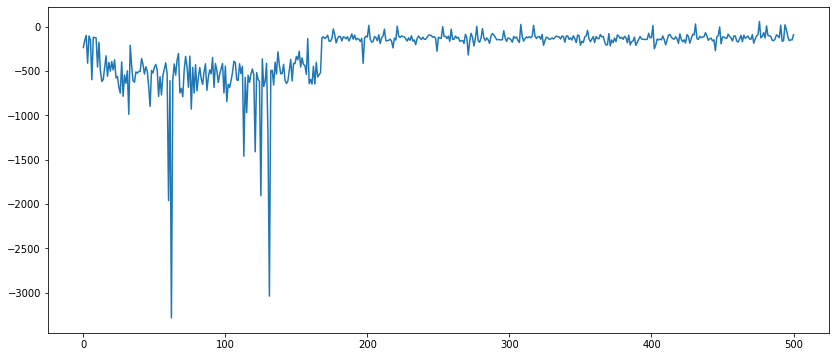

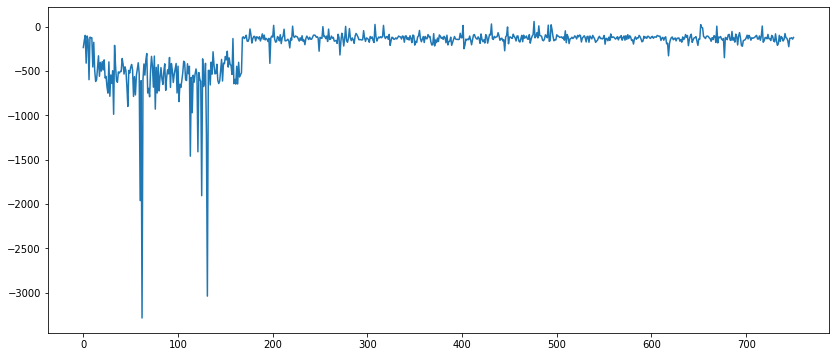

In [164]:
# Uczenie/testowania agenta
import numpy as np
env = gym.make("LunarLander-v2")

agent = NeuralQLearningAgent(env)
rewards = run_agent_in_env(env, agent, 1000, learning=True, plot=True, plot_interval=250)

In [165]:
print(np.min(rewards))
print(np.mean(rewards))
print(np.max(rewards))

-3286.479106299617
-204.76233419841498
59.859679047881144


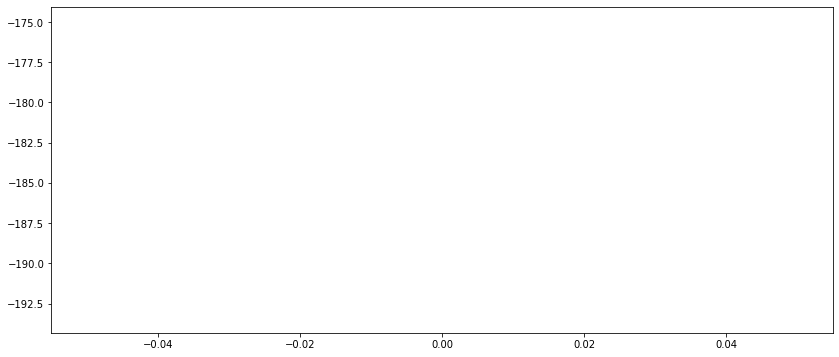

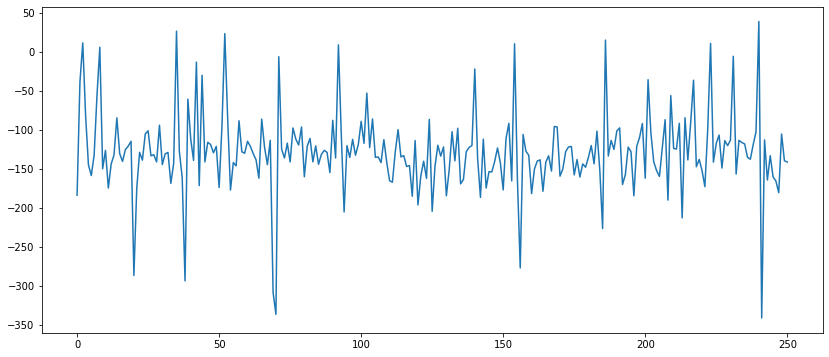

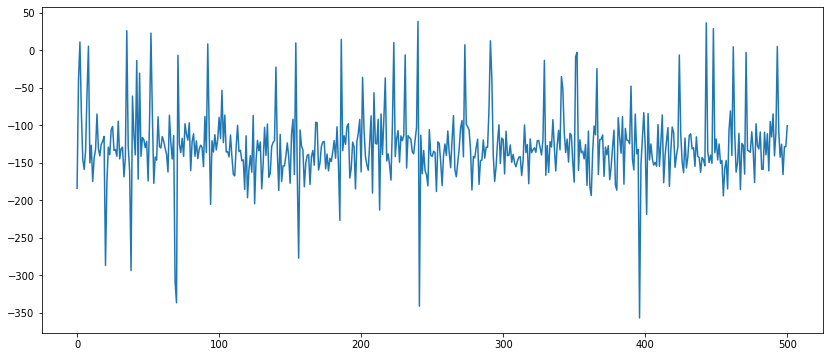

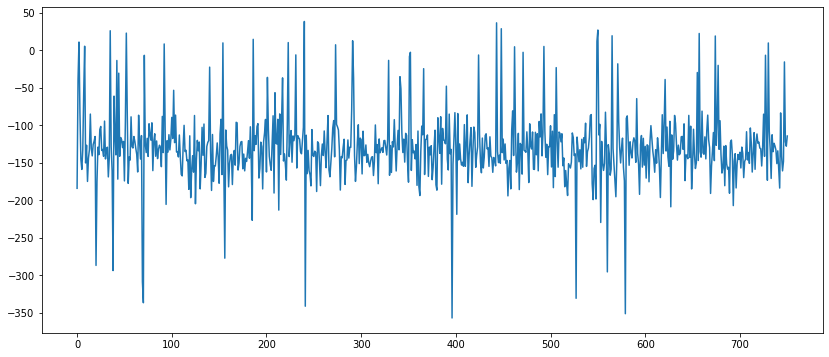

In [166]:
new_rewards = run_agent_in_env(env, agent, 1000, learning=False, plot=True, plot_interval=250)

In [167]:
print(np.min(new_rewards))
print(np.mean(new_rewards))
print(np.max(new_rewards))

-357.27192610801393
-129.88244772616088
38.552863623839585


##### Adam + MSELoss

In [179]:
import torch as T
import torch.nn.functional as F
import torch.optim as optim

class LearningModel(T.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output, n_hidden_2, learning_rate):
        super(LearningModel, self).__init__()
        self.n_feature = n_feature 
        self.n_hidden = n_hidden
        self.n_hidden_2 = n_hidden_2
        self.n_output = n_output

        self.fc1 = T.nn.Linear(*self.n_feature, self.n_hidden)
        self.fc2 = T.nn.Linear(self.n_hidden, self.n_hidden_2)
        self.fc3 = T.nn.Linear(self.n_hidden_2, self.n_output)

        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate) # Adagrad
        self.loss = T.nn.MSELoss() #MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        x = F.relu(self.fc1(state))    
        x = F.relu(self.fc2(x))     
        actions = self.fc3(x)             

        return actions

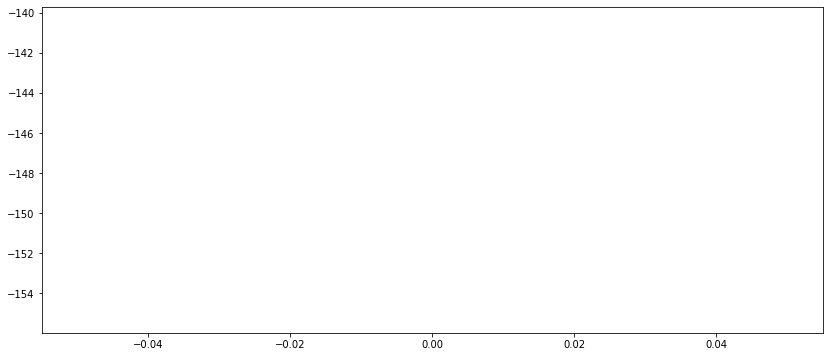

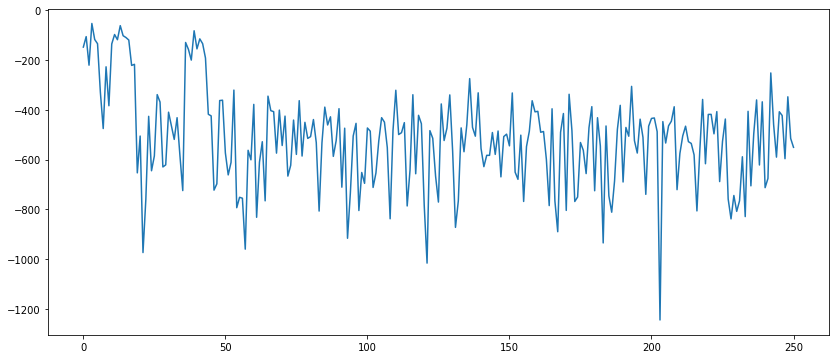

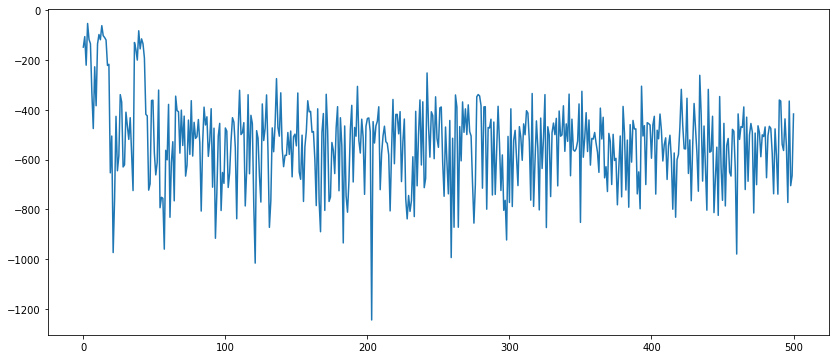

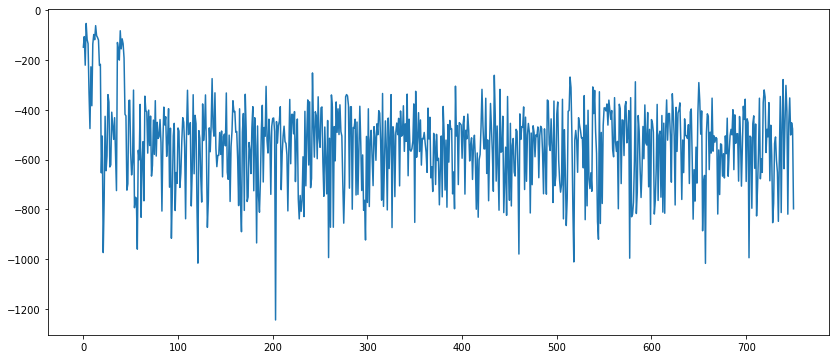

In [180]:
# Uczenie/testowania agenta
import numpy as np
env = gym.make("LunarLander-v2")

agent = NeuralQLearningAgent(env)
rewards = run_agent_in_env(env, agent, 1000, learning=True, plot=True, plot_interval=250)

In [181]:
print(np.min(rewards))
print(np.mean(rewards))
print(np.max(rewards))

-3105.2482327216703
-556.1001921565561
-52.827347076538835


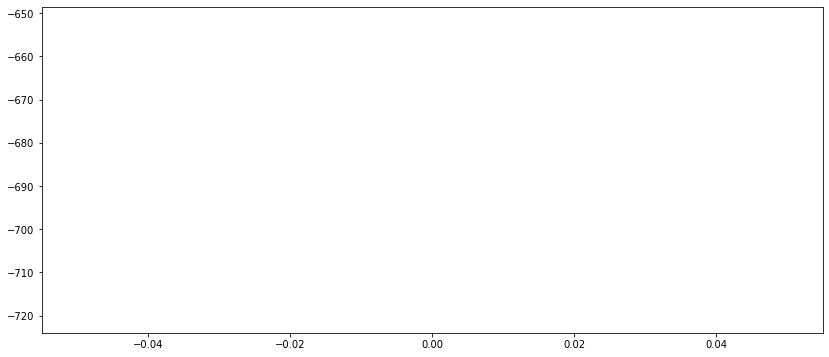

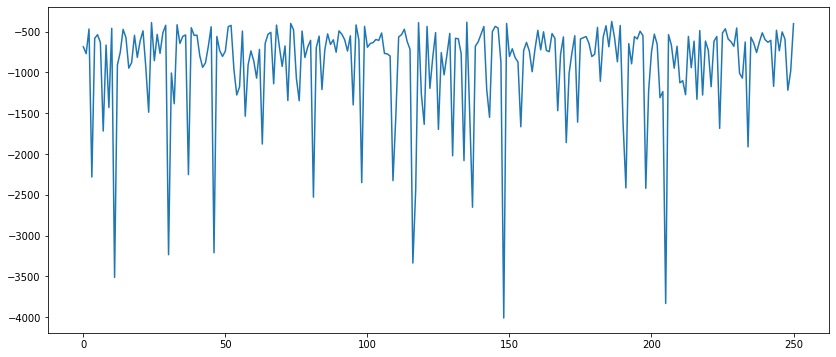

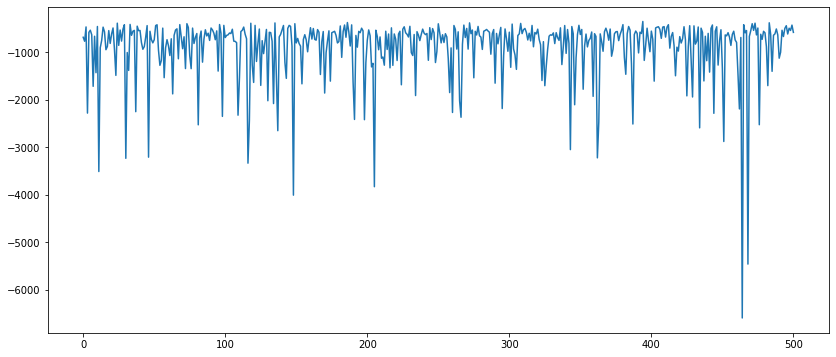

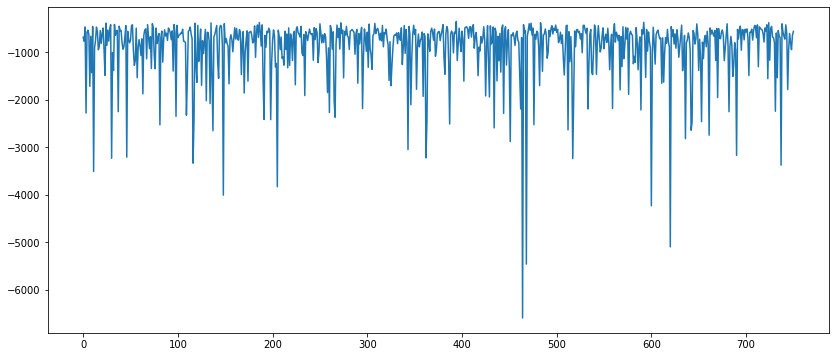

In [182]:
new_rewards = run_agent_in_env(env, agent, 1000, learning=False, plot=True, plot_interval=250)

In [183]:
print(np.min(new_rewards))
print(np.mean(new_rewards))
print(np.max(new_rewards))

-6592.277312461641
-895.7618428154278
-348.35088567371906


##### Adagrad

In [186]:
import torch as T
import torch.nn.functional as F
import torch.optim as optim

class LearningModel(T.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output, n_hidden_2, learning_rate):
        super(LearningModel, self).__init__()
        self.n_feature = n_feature 
        self.n_hidden = n_hidden
        self.n_hidden_2 = n_hidden_2
        self.n_output = n_output

        self.fc1 = T.nn.Linear(*self.n_feature, self.n_hidden)
        self.fc2 = T.nn.Linear(self.n_hidden, self.n_hidden_2)
        self.fc3 = T.nn.Linear(self.n_hidden_2, self.n_output)

        self.optimizer = optim.Adagrad(self.parameters(), lr=learning_rate) # Adagrad
        self.loss = T.nn.PoissonNLLLoss() #MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        x = F.relu(self.fc1(state))    
        x = F.relu(self.fc2(x))     
        actions = self.fc3(x)             

        return actions

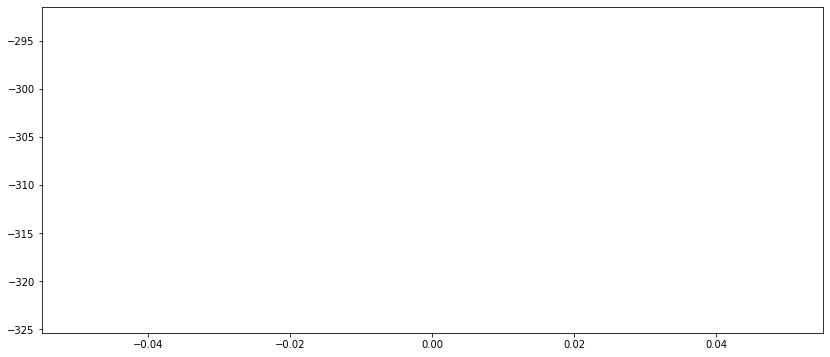

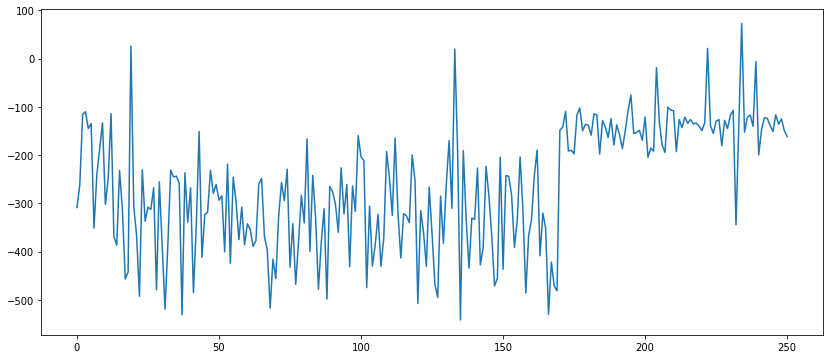

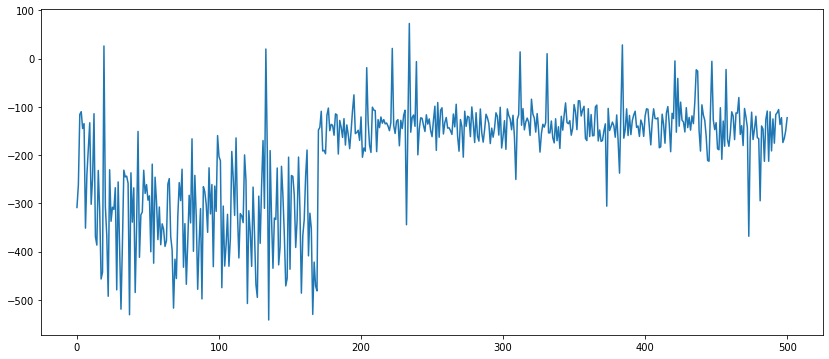

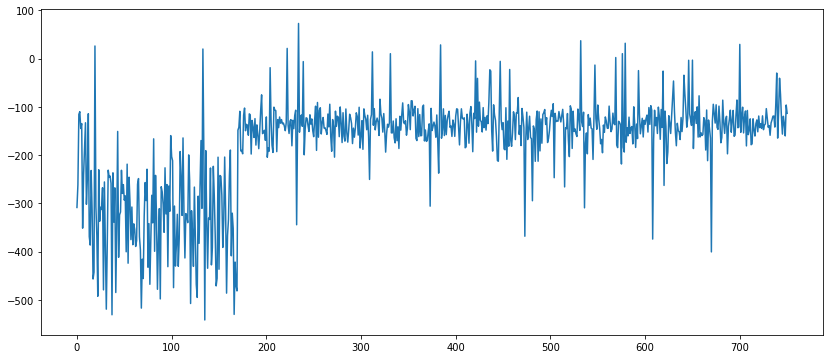

In [187]:
# Uczenie/testowania agenta
import numpy as np
env = gym.make("LunarLander-v2")

agent = NeuralQLearningAgent(env)
rewards = run_agent_in_env(env, agent, 1000, learning=True, plot=True, plot_interval=250)

In [188]:
print(np.min(rewards))
print(np.mean(rewards))
print(np.max(rewards))

-541.7087007957457
-167.58630144250887
73.1096678594024


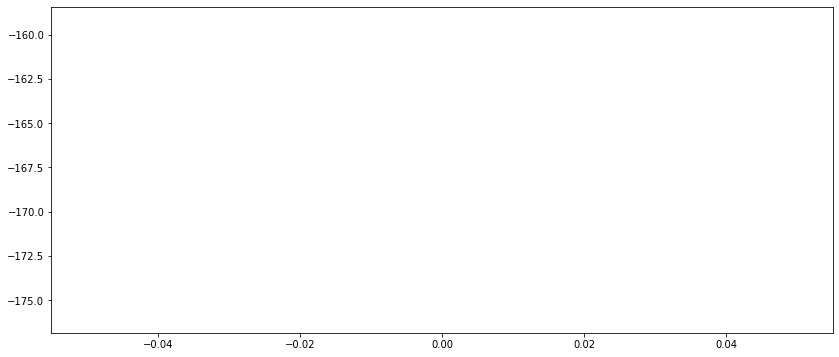

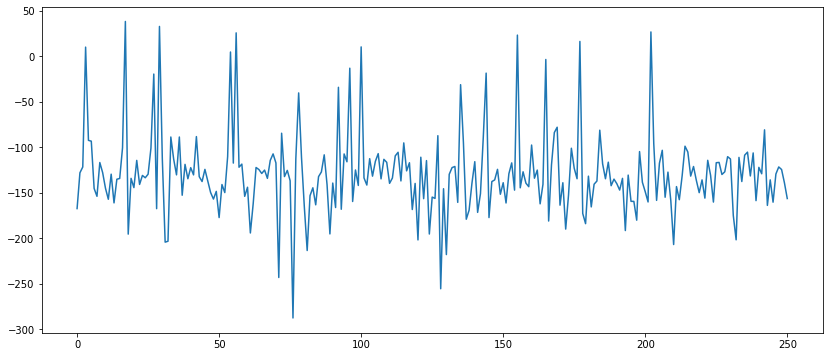

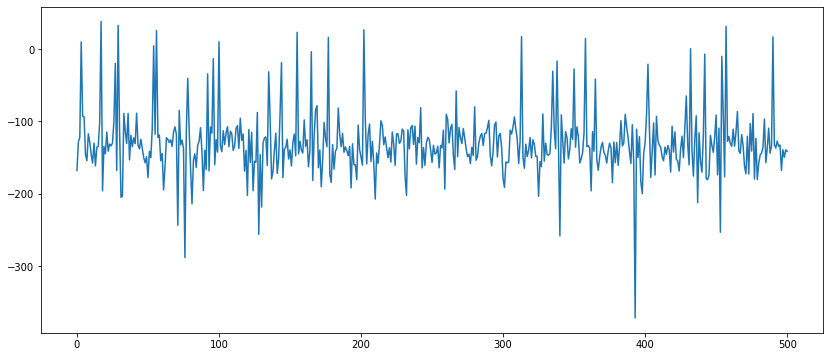

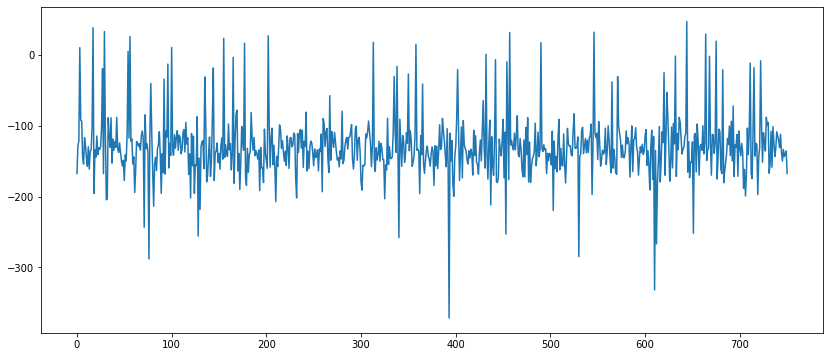

In [189]:
new_rewards = run_agent_in_env(env, agent, 1000, learning=False, plot=True, plot_interval=250)

In [190]:
print(np.min(new_rewards))
print(np.mean(new_rewards))
print(np.max(new_rewards))

-371.2944316523888
-129.65042708132393
52.79154855258906


##### Adagrad + MSELoss

In [191]:
import torch as T
import torch.nn.functional as F
import torch.optim as optim

class LearningModel(T.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output, n_hidden_2, learning_rate):
        super(LearningModel, self).__init__()
        self.n_feature = n_feature 
        self.n_hidden = n_hidden
        self.n_hidden_2 = n_hidden_2
        self.n_output = n_output

        self.fc1 = T.nn.Linear(*self.n_feature, self.n_hidden)
        self.fc2 = T.nn.Linear(self.n_hidden, self.n_hidden_2)
        self.fc3 = T.nn.Linear(self.n_hidden_2, self.n_output)

        self.optimizer = optim.Adagrad(self.parameters(), lr=learning_rate) # Adagrad
        self.loss = T.nn.MSELoss() #MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        x = F.relu(self.fc1(state))    
        x = F.relu(self.fc2(x))     
        actions = self.fc3(x)             

        return actions

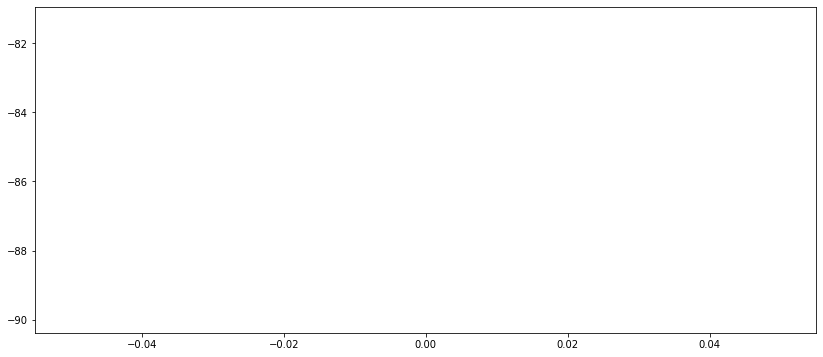

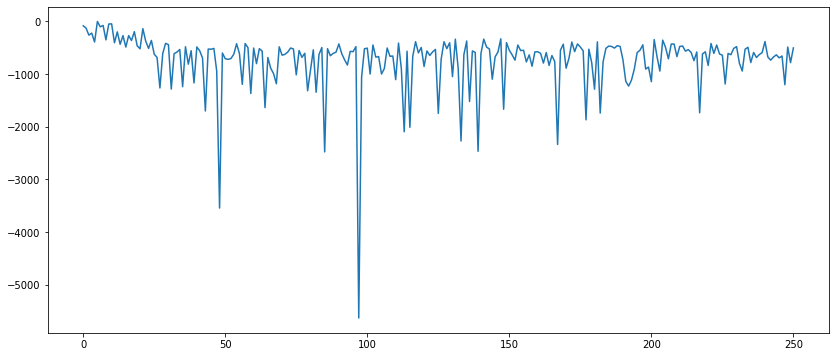

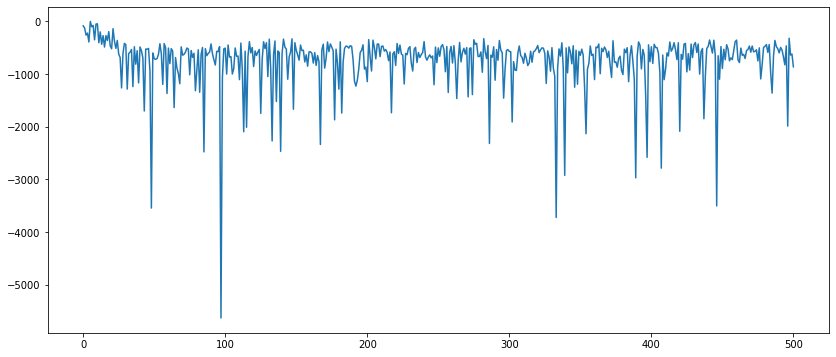

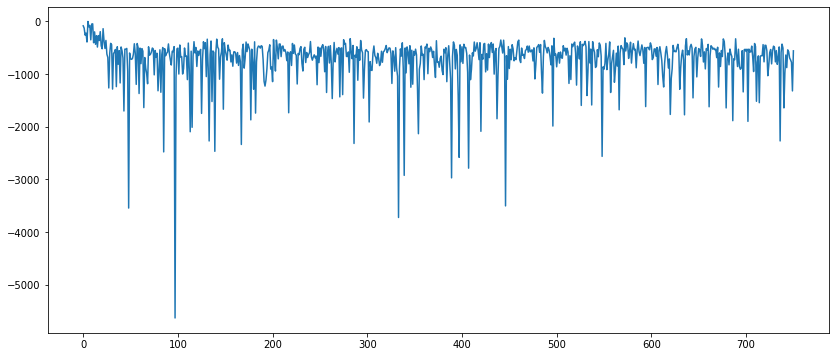

In [192]:
# Uczenie/testowania agenta
import numpy as np
env = gym.make("LunarLander-v2")

agent = NeuralQLearningAgent(env)
rewards = run_agent_in_env(env, agent, 1000, learning=True, plot=True, plot_interval=250)

In [193]:
print(np.min(rewards))
print(np.mean(rewards))
print(np.max(rewards))

-5630.971032189
-712.7997139664207
-3.072747954763301


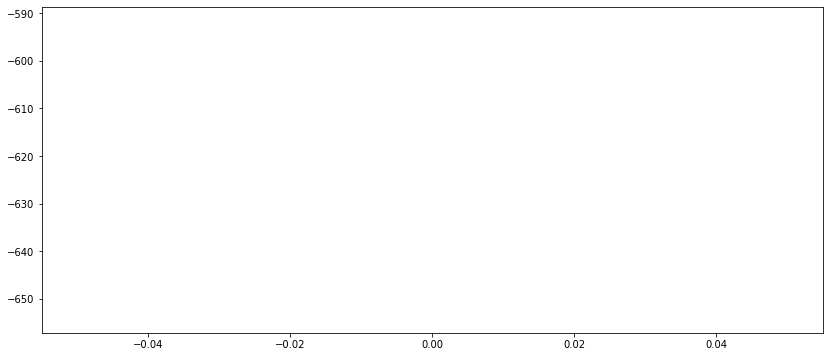

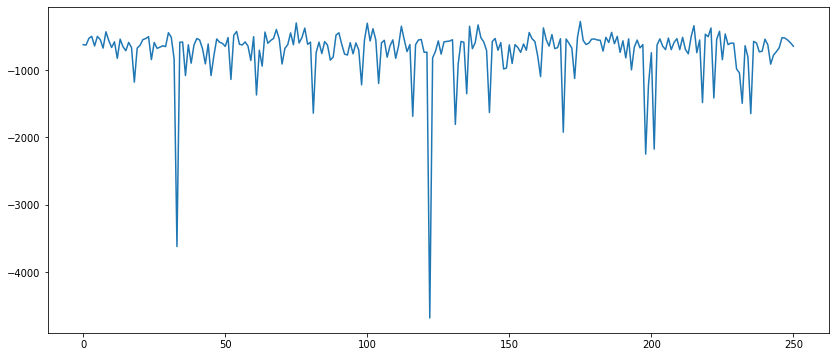

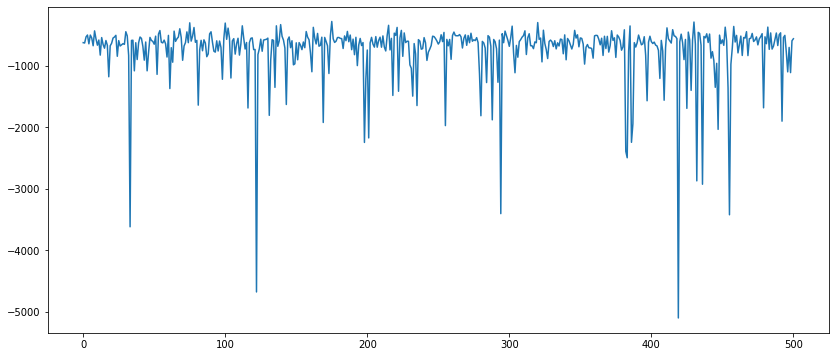

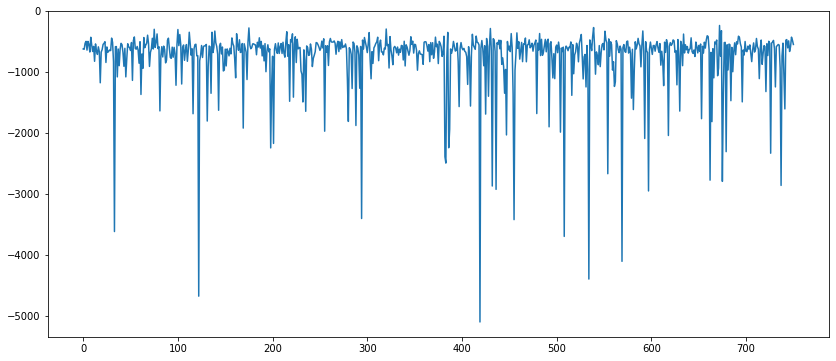

In [194]:
new_rewards = run_agent_in_env(env, agent, 1000, learning=False, plot=True, plot_interval=250)

In [195]:
print(np.min(new_rewards))
print(np.mean(new_rewards))
print(np.max(new_rewards))

-5104.265550950831
-751.2001948115118
-237.5520382755738


##### Epsilon=0.5

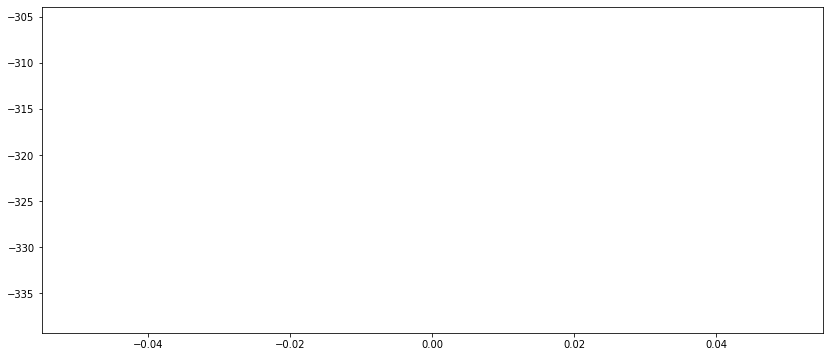

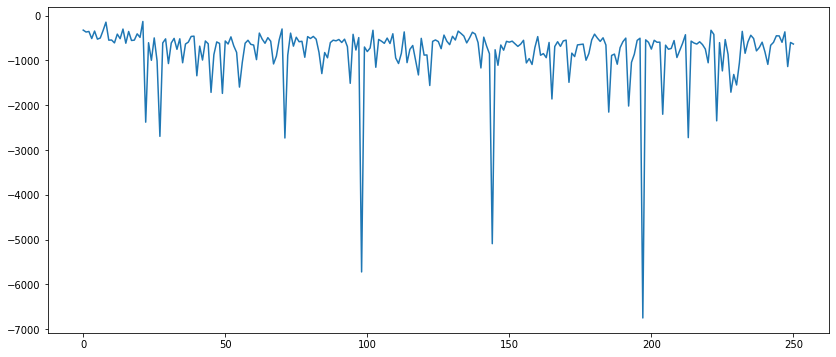

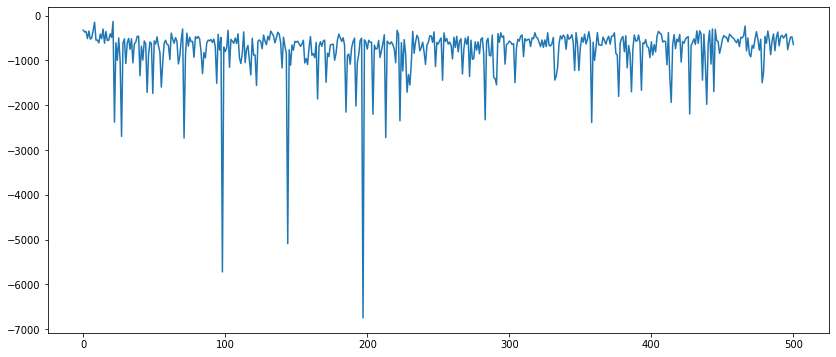

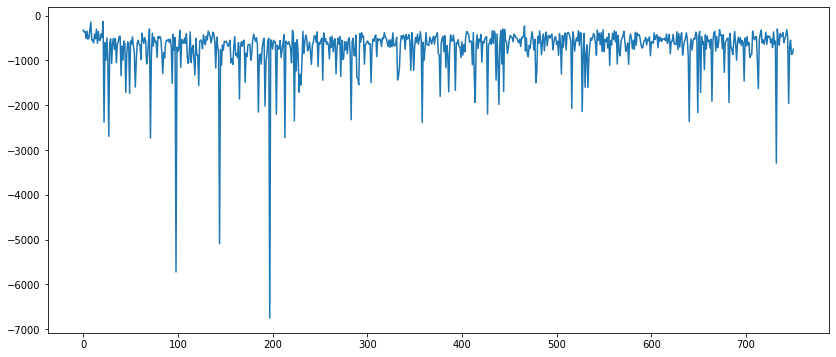

In [196]:
# Uczenie/testowania agenta
import numpy as np
env = gym.make("LunarLander-v2")

agent = NeuralQLearningAgent(env, epsilon = 0.5)
rewards = run_agent_in_env(env, agent, 1000, learning=True, plot=True, plot_interval=250)

In [197]:
print(np.min(rewards))
print(np.mean(rewards))
print(np.max(rewards))

-6752.3085847517705
-700.5153894837613
-128.7007854003662


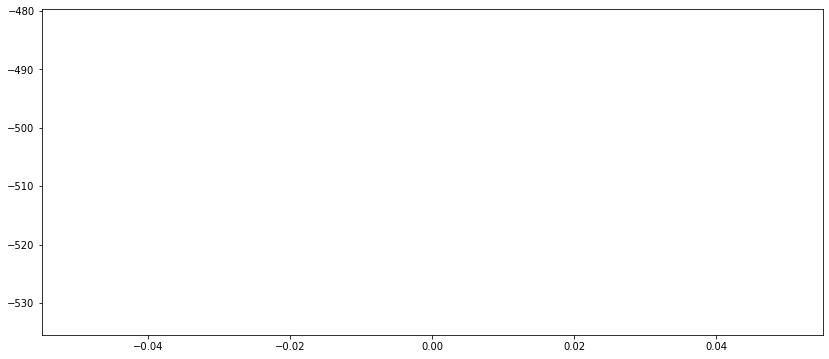

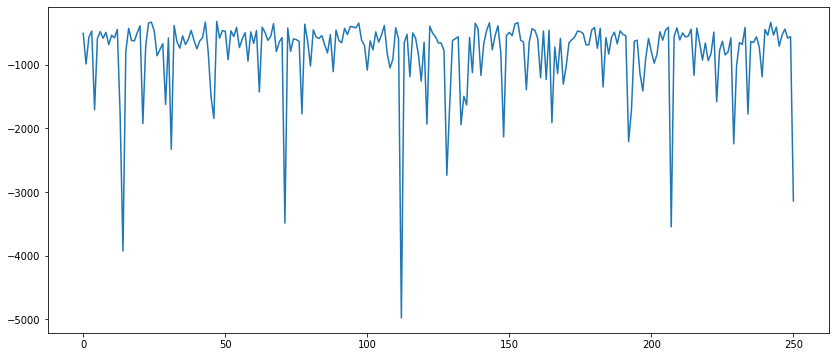

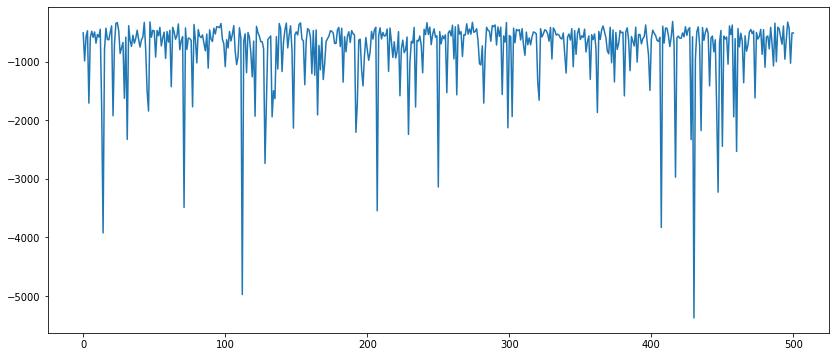

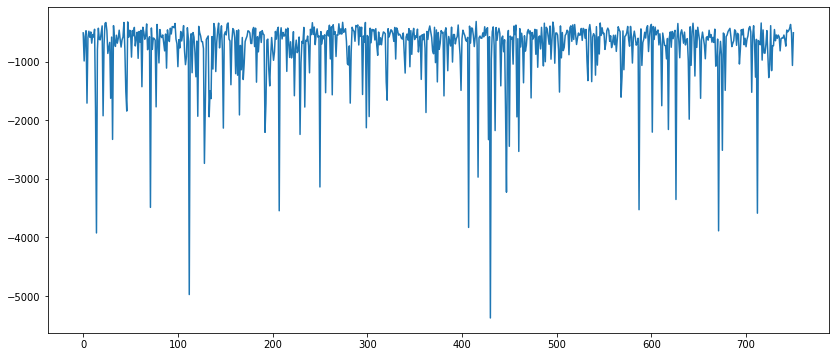

In [198]:
new_rewards = run_agent_in_env(env, agent, 1000, learning=False, plot=True, plot_interval=250)

In [199]:
print(np.min(new_rewards))
print(np.mean(new_rewards))
print(np.max(new_rewards))

-5376.262216284516
-746.4508936422893
-312.52667908604997


##### Epsilon=1.5

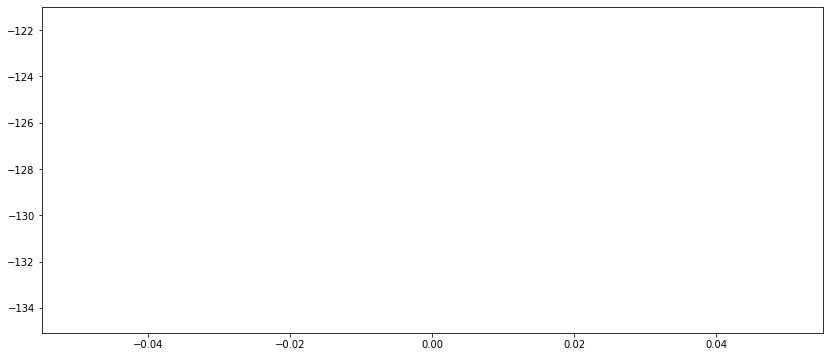

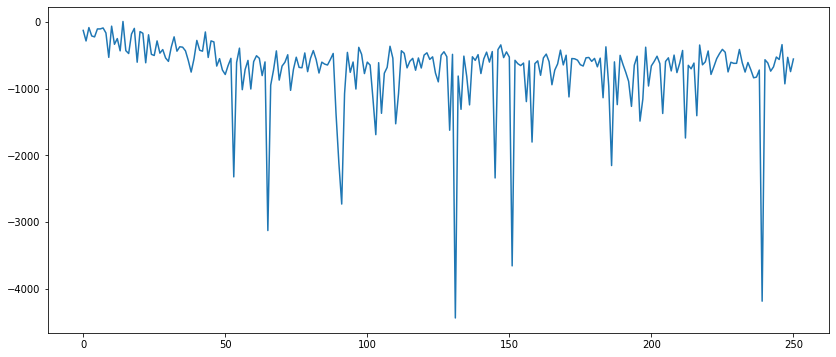

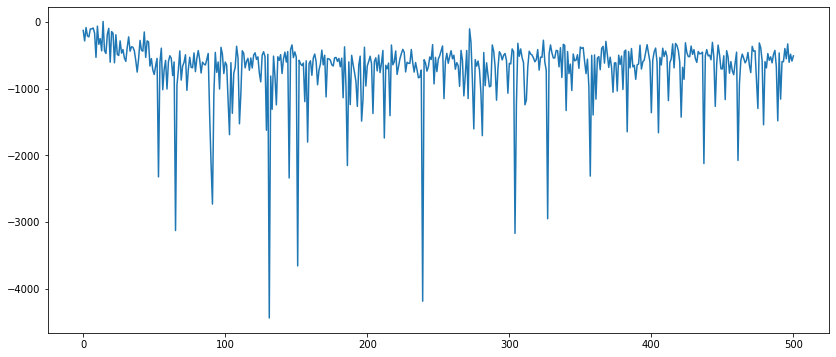

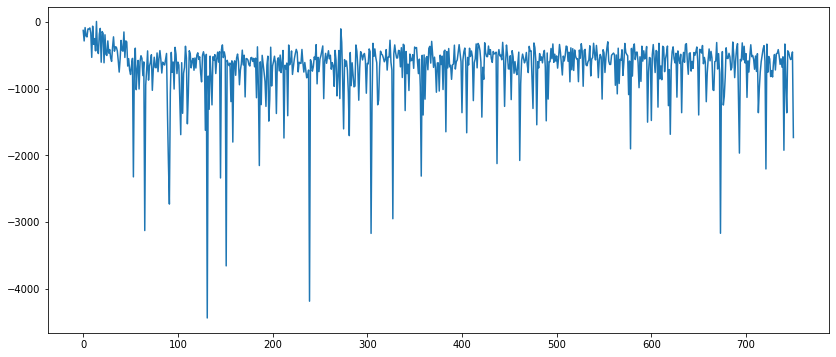

In [204]:
# Uczenie/testowania agenta
import numpy as np
env = gym.make("LunarLander-v2")

agent = NeuralQLearningAgent(env, epsilon = 1.5)
rewards = run_agent_in_env(env, agent, 1000, learning=True, plot=True, plot_interval=250)

In [205]:
print(np.min(rewards))
print(np.mean(rewards))
print(np.max(rewards))

-4440.4606827105845
-673.2095787938985
5.993835213031247


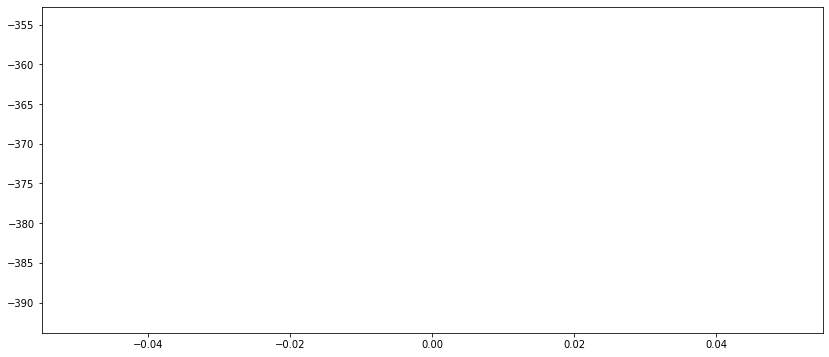

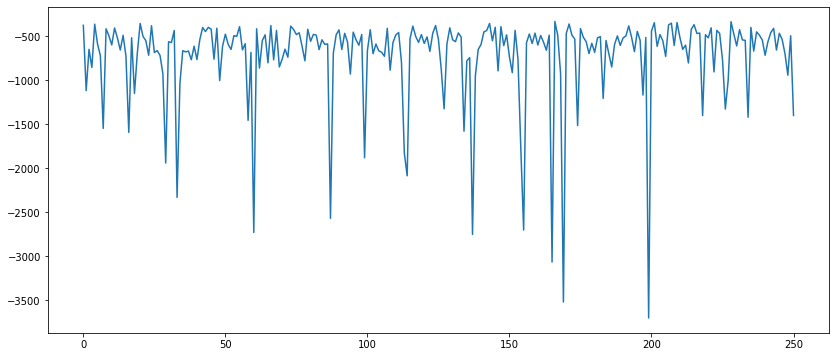

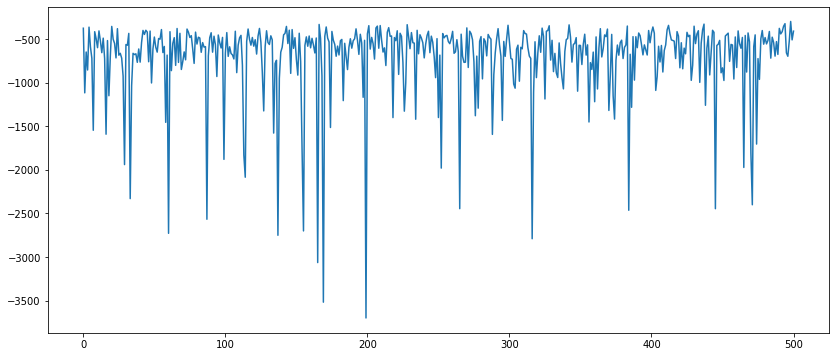

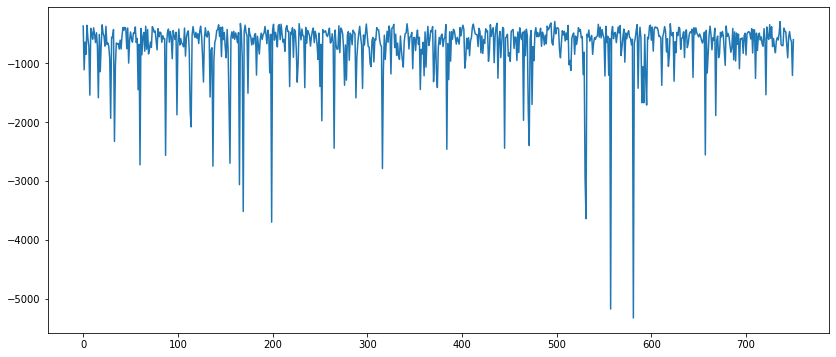

In [206]:
new_rewards = run_agent_in_env(env, agent, 1000, learning=False, plot=True, plot_interval=250)

In [207]:
print(np.min(new_rewards))
print(np.mean(new_rewards))
print(np.max(new_rewards))

-5324.840084804422
-705.6021043336799
-295.6380566858821


##### learning_rate=0.1

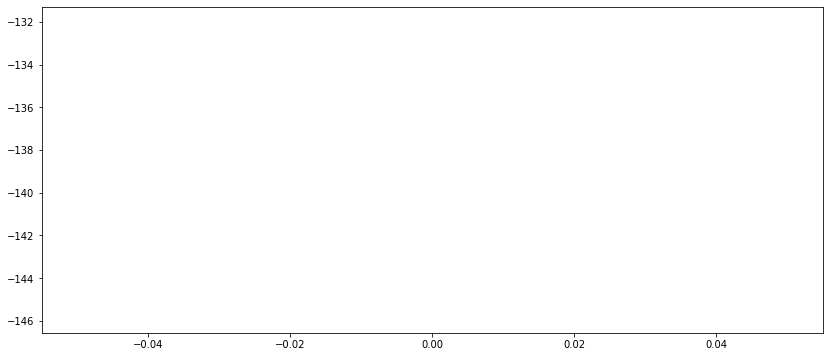

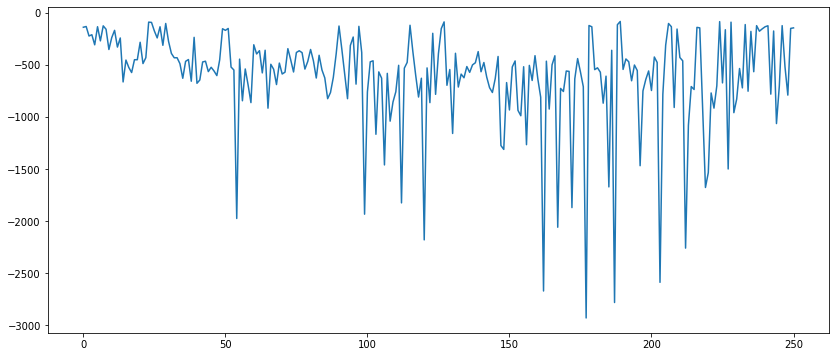

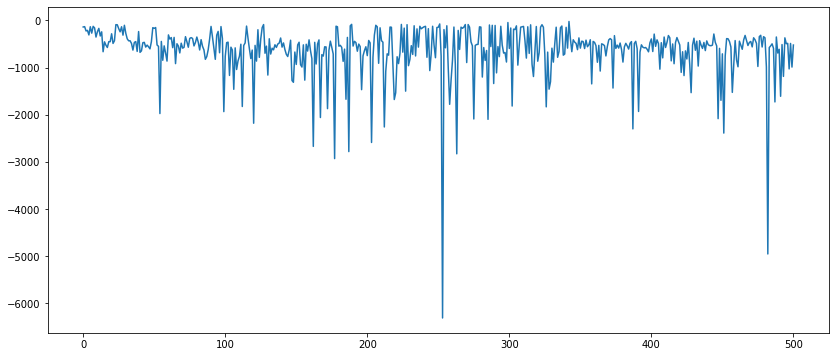

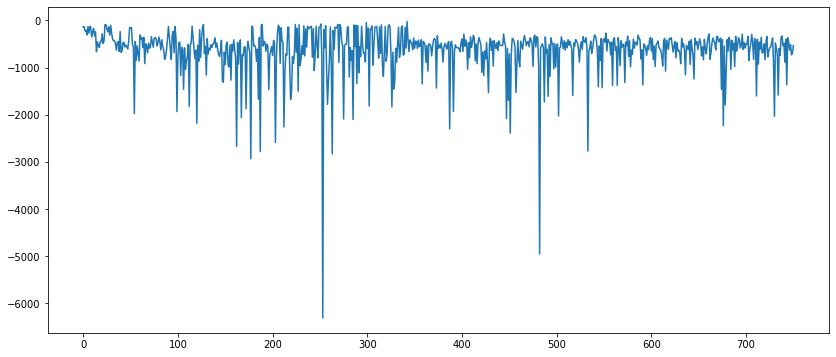

In [200]:
# Uczenie/testowania agenta
import numpy as np
env = gym.make("LunarLander-v2")

agent = NeuralQLearningAgent(env, learning_rate=0.1)
rewards = run_agent_in_env(env, agent, 1000, learning=True, plot=True, plot_interval=250)

In [201]:
print(np.min(rewards))
print(np.mean(rewards))
print(np.max(rewards))

-6310.469117448345
-643.1774046143801
-21.922570600274938


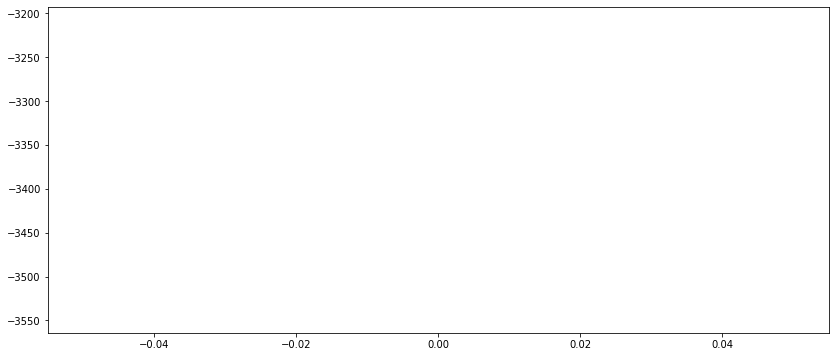

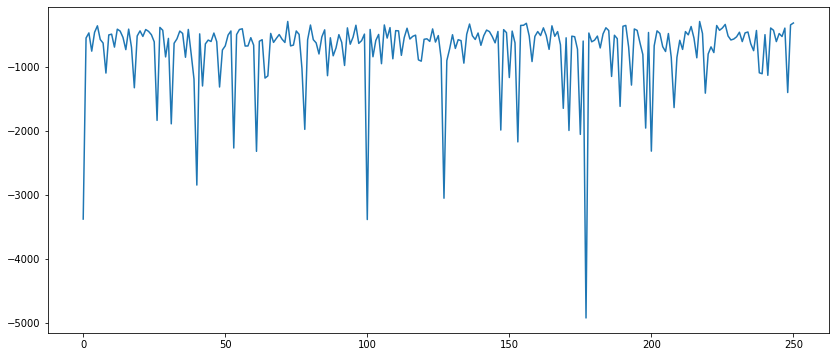

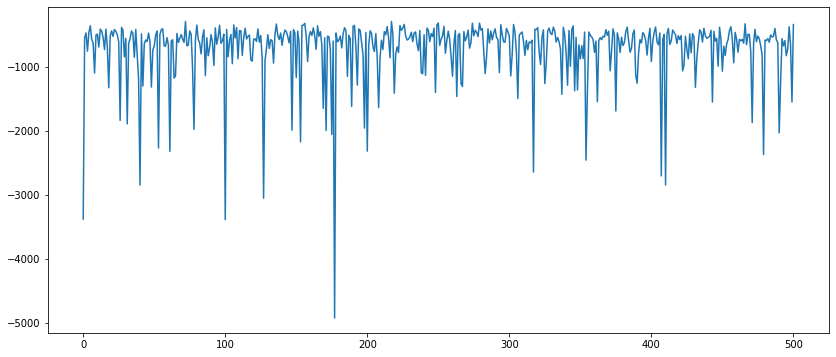

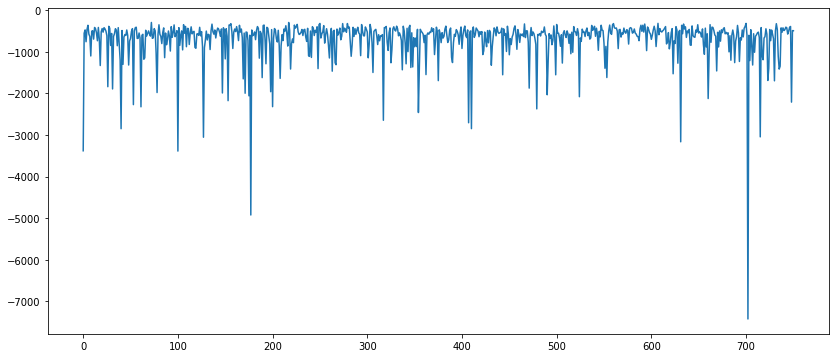

In [202]:
new_rewards = run_agent_in_env(env, agent, 1000, learning=False, plot=True, plot_interval=250)

In [203]:
print(np.min(new_rewards))
print(np.mean(new_rewards))
print(np.max(new_rewards))

-7424.772884895859
-713.0843263612721
-291.7397953765211


##### learning_rate=0.4

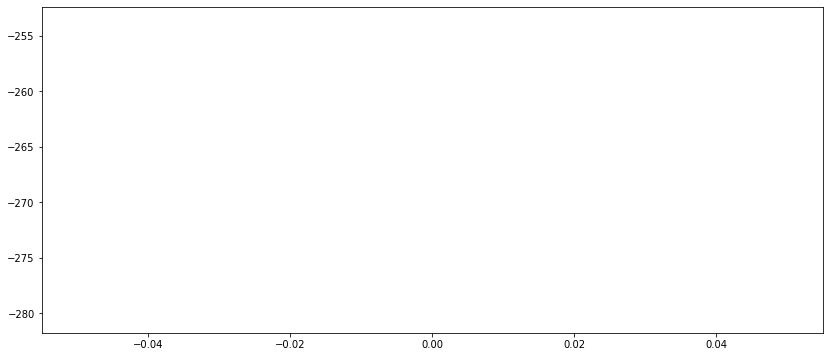

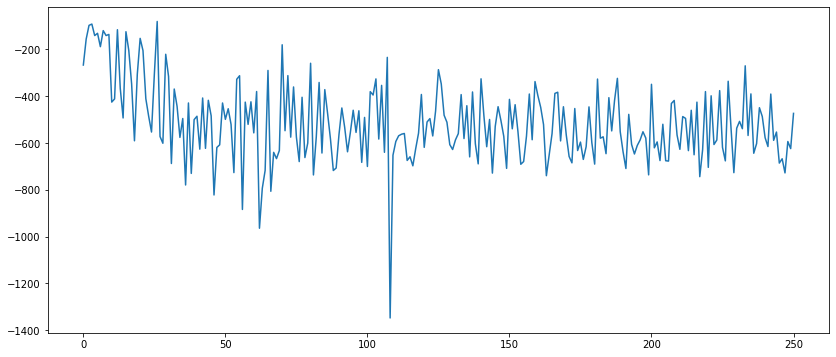

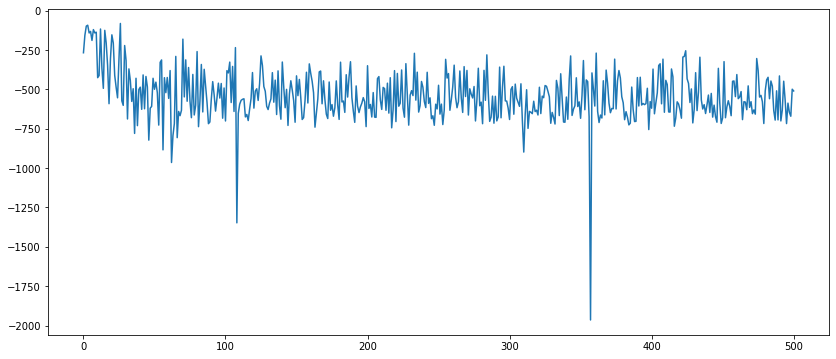

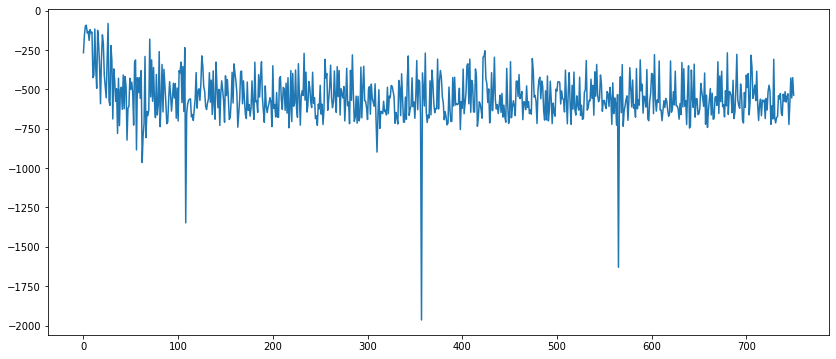

In [208]:
# Uczenie/testowania agenta
import numpy as np
env = gym.make("LunarLander-v2")

agent = NeuralQLearningAgent(env, learning_rate=0.4)
rewards = run_agent_in_env(env, agent, 1000, learning=True, plot=True, plot_interval=250)

In [209]:
print(np.min(rewards))
print(np.mean(rewards))
print(np.max(rewards))

-1964.840123717265
-545.5236227385444
-80.94723624589341


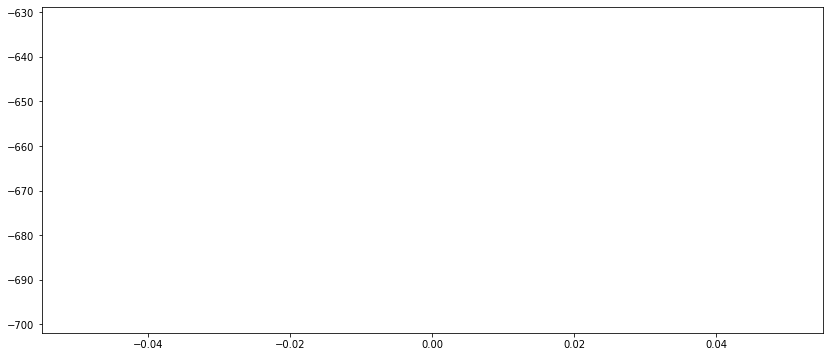

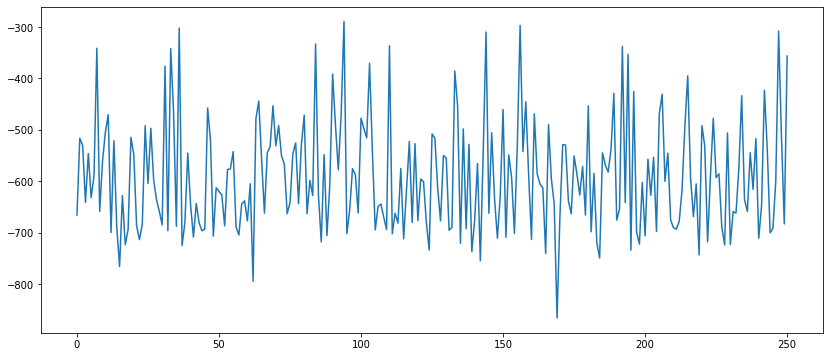

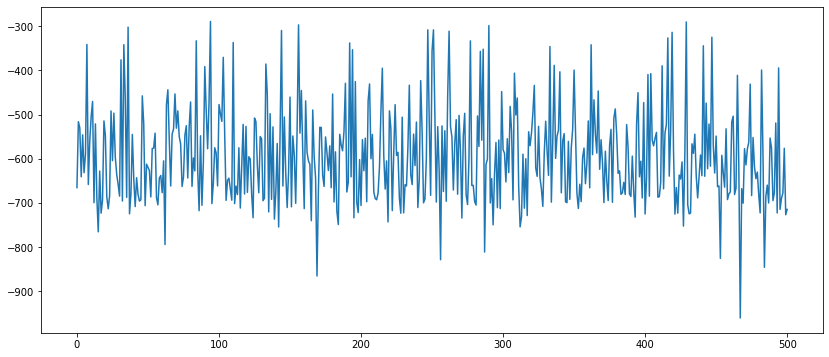

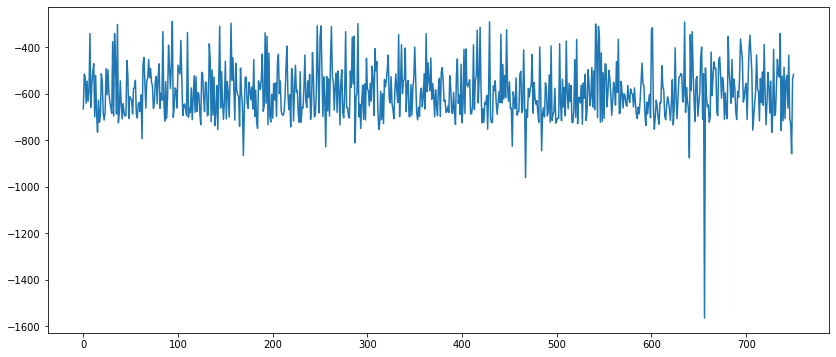

In [210]:
new_rewards = run_agent_in_env(env, agent, 1000, learning=False, plot=True, plot_interval=250)

In [211]:
print(np.min(new_rewards))
print(np.mean(new_rewards))
print(np.max(new_rewards))

-1564.5690645521106
-591.7425729945905
-279.7070764048502


#### Uczenie agenta - wersja podstawowa 

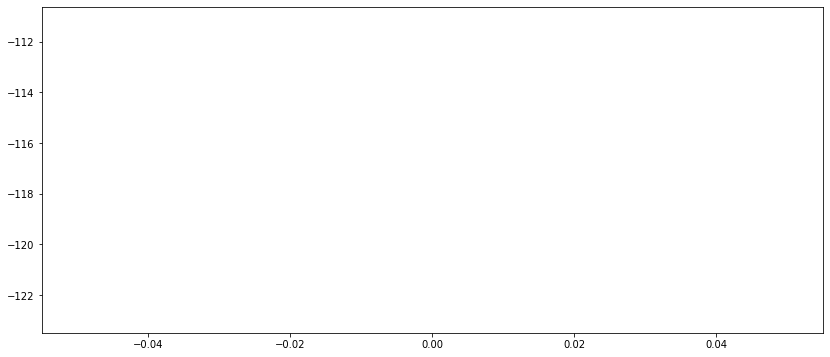

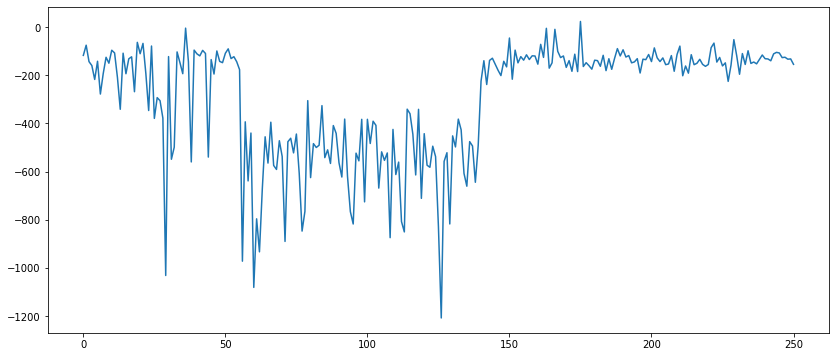

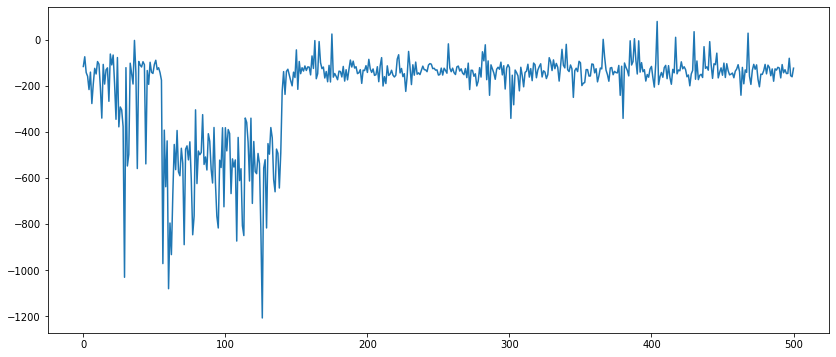

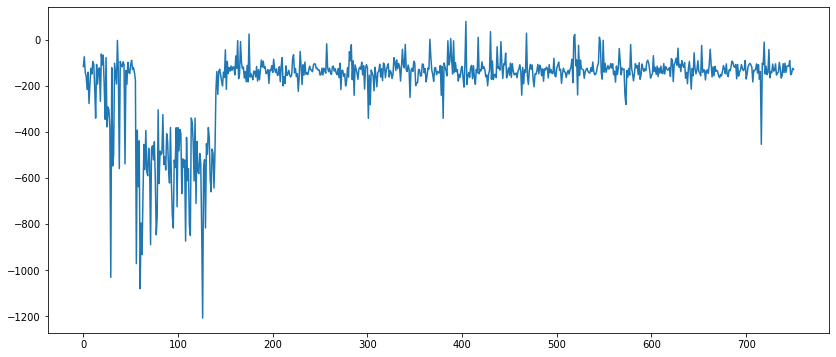

In [144]:
# Uczenie/testowania agenta
import numpy as np
env = gym.make("LunarLander-v2")

agent = NeuralQLearningAgent(env)
rewards = run_agent_in_env(env, agent, 1000, learning=True, plot=True, plot_interval=250)

In [145]:
print(np.min(rewards))
print(np.mean(rewards))
print(np.max(rewards))

-1208.1102094589783
-173.6269604672846
78.27463727413058


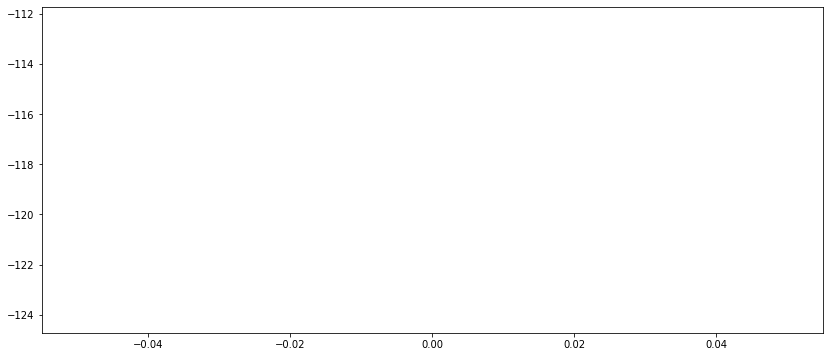

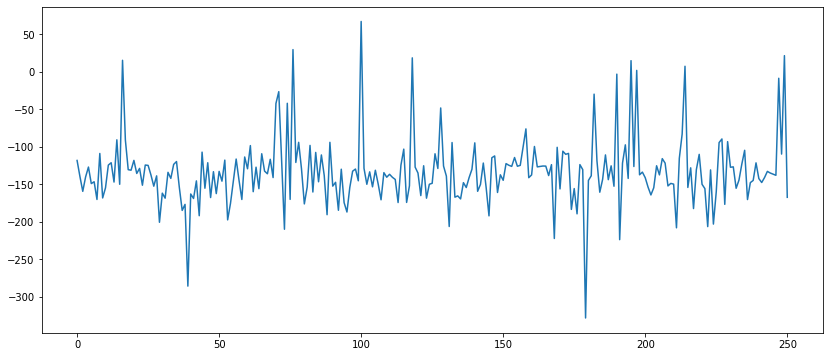

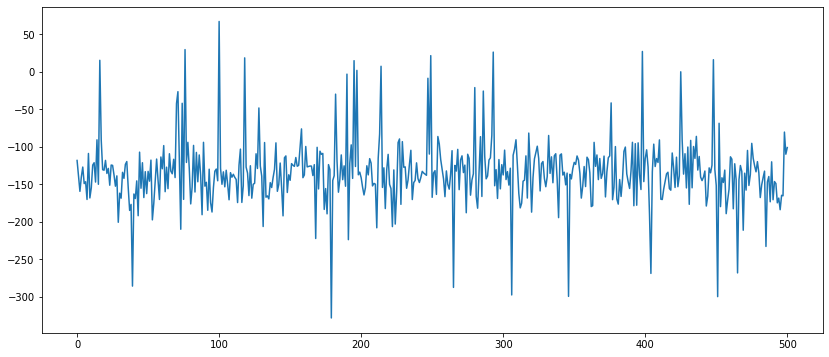

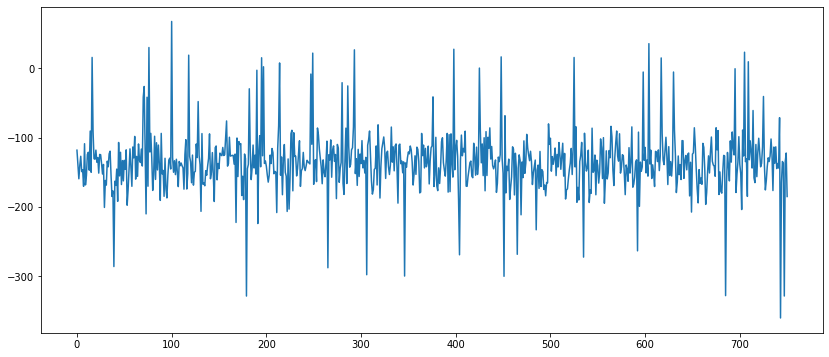

In [146]:
new_rewards = run_agent_in_env(env, agent, 1000, learning=False, plot=True, plot_interval=250)

In [147]:
print(np.min(new_rewards))
print(np.mean(new_rewards))
print(np.max(new_rewards))

-360.15497123730677
-135.10650139610945
67.37771445782187


#### Uczenie agenata - replay memory

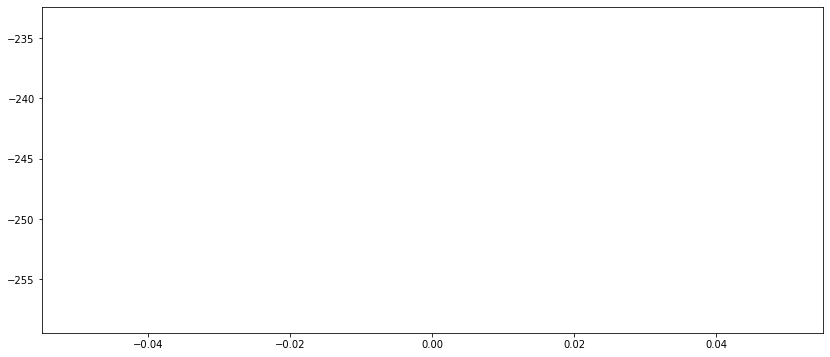

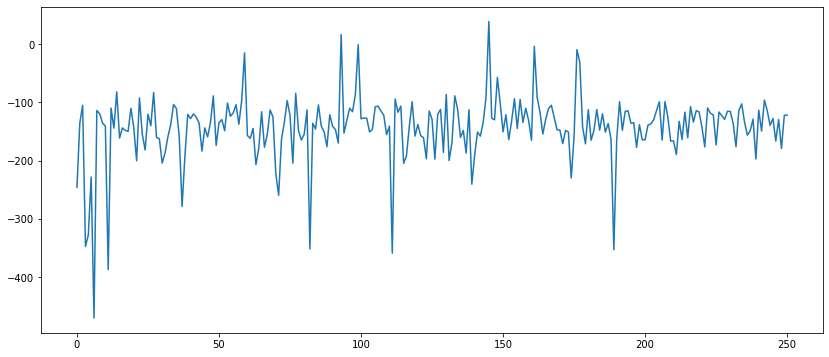

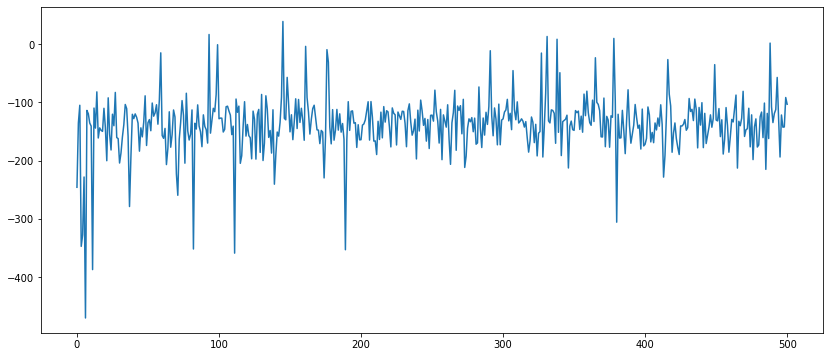

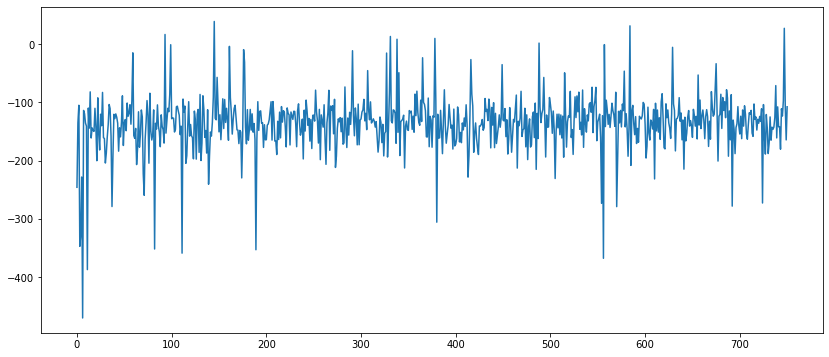

In [148]:
# Uczenie/testowania agenta
import numpy as np
env = gym.make("LunarLander-v2")

agent = NeuralQLearningAgent(env, batch_learning=True)
rewards = run_agent_in_env(env, agent, 1000, learning=True, plot=True, plot_interval=250)

In [149]:
print(np.min(rewards))
print(np.mean(rewards))
print(np.max(rewards))

-470.1348498599541
-136.49586513948162
47.30829904669133


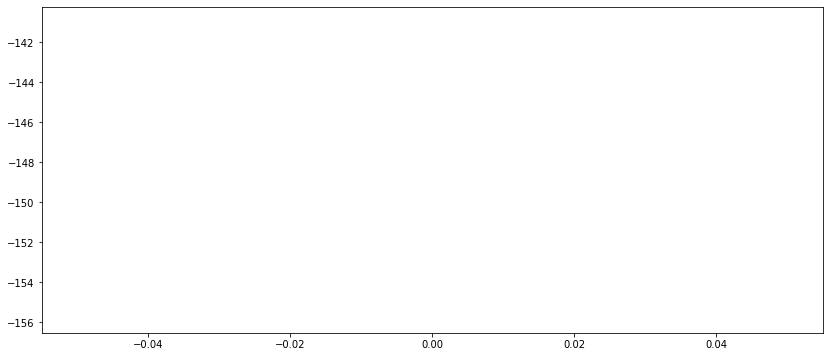

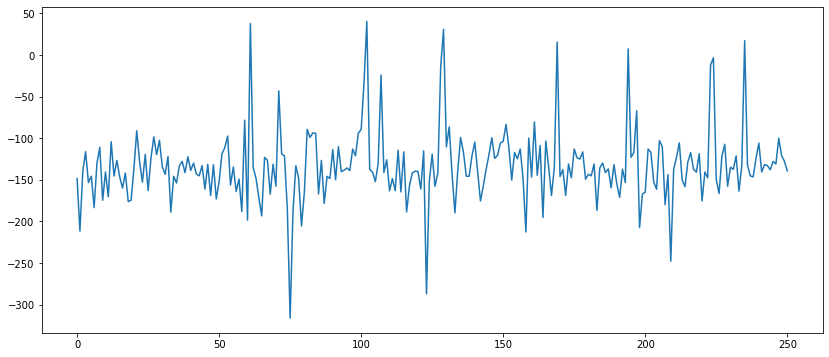

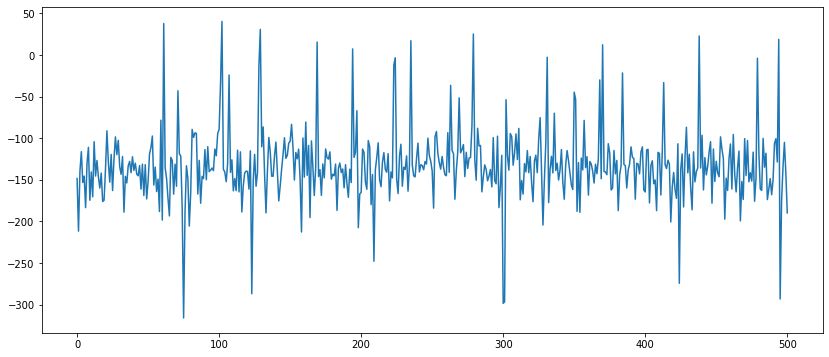

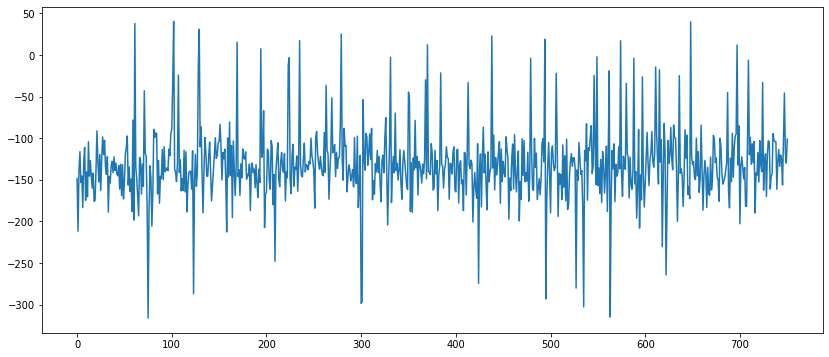

In [150]:
new_rewards = run_agent_in_env(env, agent, 1000, learning=False, plot=True, plot_interval=250)

In [151]:
print(np.min(new_rewards))
print(np.mean(new_rewards))
print(np.max(new_rewards))

-323.22567080736167
-130.6746856397109
40.25214129170709


#### Uczenie agenata - network_freezing

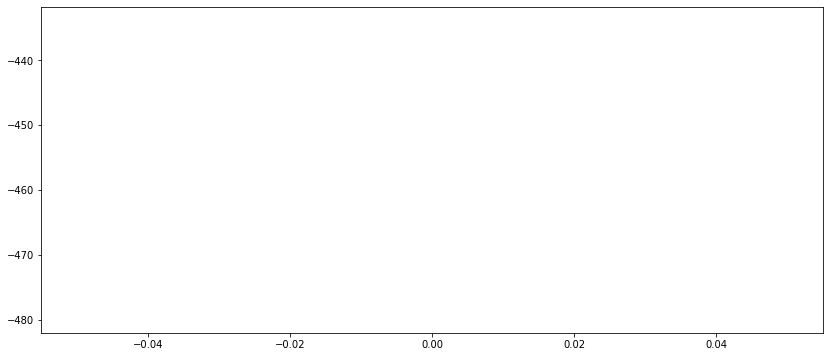

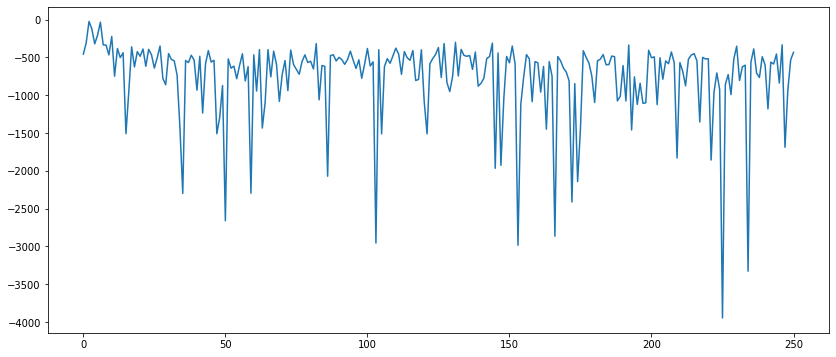

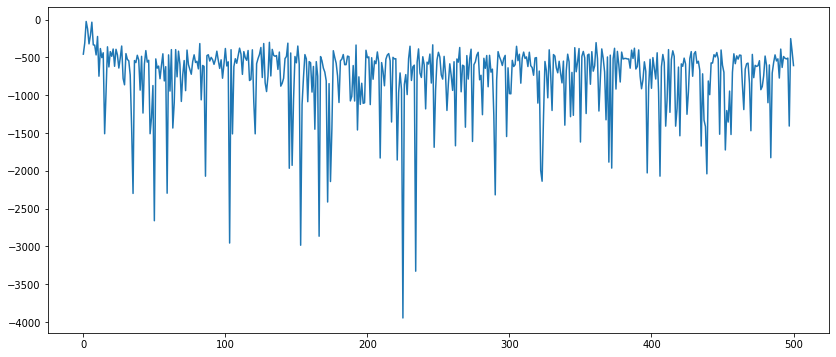

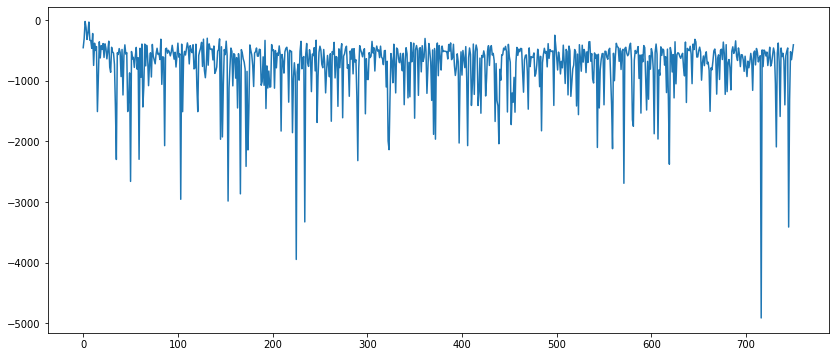

In [152]:
# Uczenie/testowania agenta
import numpy as np
env = gym.make("LunarLander-v2")

agent = NeuralQLearningAgent(env, network_freezing=True)
rewards = run_agent_in_env(env, agent, 1000, learning=True, plot=True, plot_interval=250)

In [153]:
print(np.min(rewards))
print(np.mean(rewards))
print(np.max(rewards))

-4909.816864859837
-752.0368984497435
-25.007326437033143


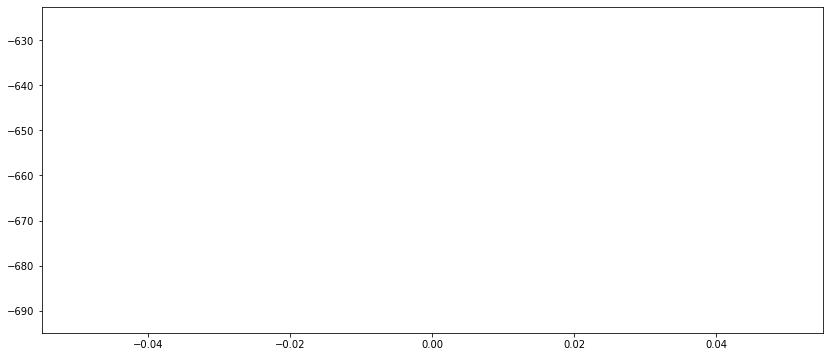

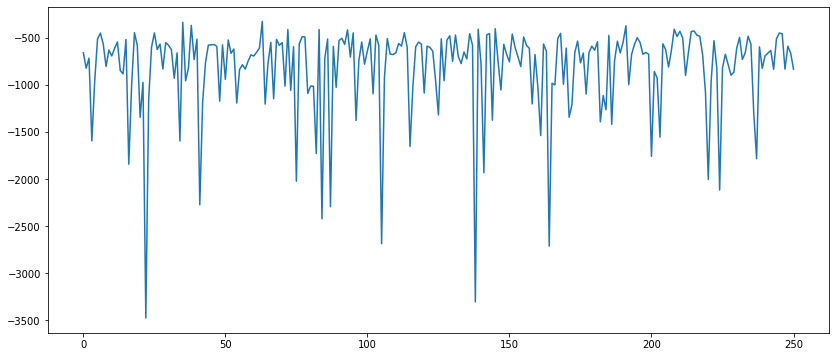

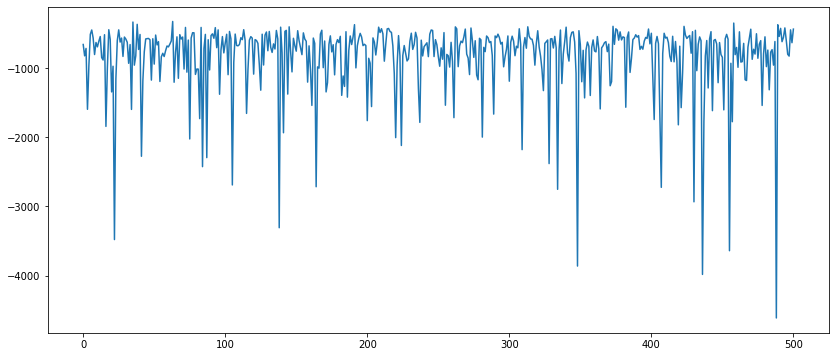

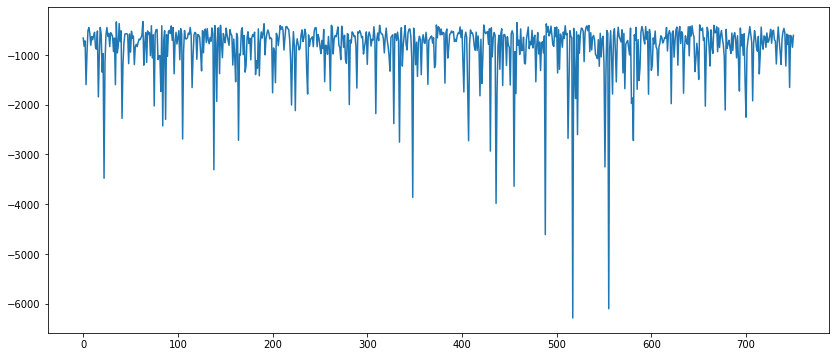

In [154]:
new_rewards = run_agent_in_env(env, agent, 1000, learning=False, plot=True, plot_interval=250)

In [155]:
print(np.min(new_rewards))
print(np.mean(new_rewards))
print(np.max(new_rewards))

-6286.2484463815135
-853.6353073742172
-325.930461478472


#### Uczenie agenata - double q_learning

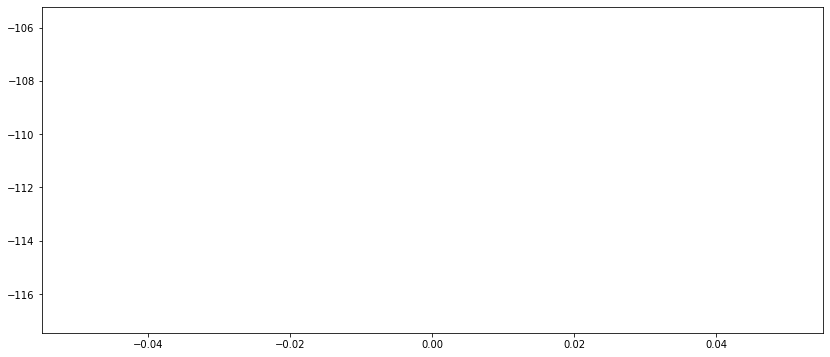

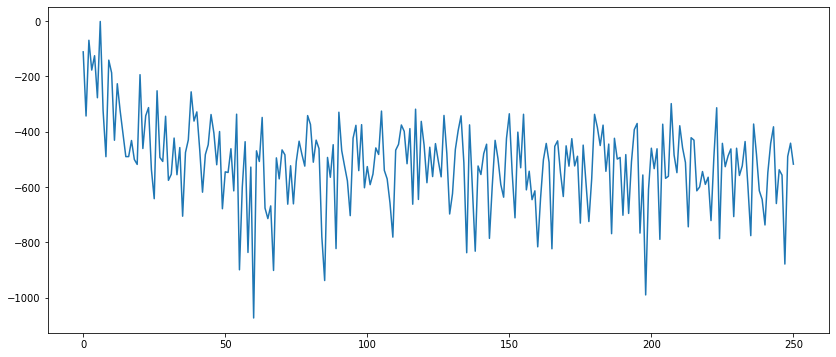

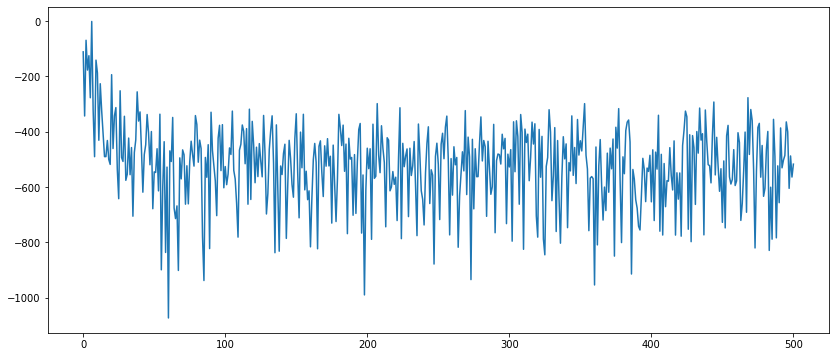

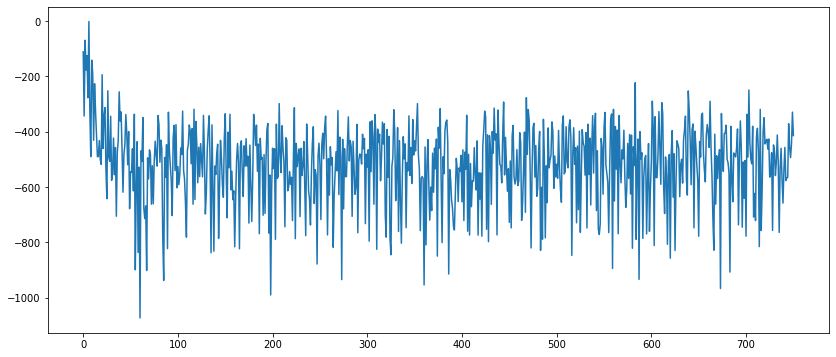

In [156]:
# Uczenie/testowania agenta
import numpy as np
env = gym.make("LunarLander-v2")

agent = NeuralQLearningAgent(env, double_learning=True)
rewards = run_agent_in_env(env, agent, 1000, learning=True, plot=True, plot_interval=250)

In [157]:
print(np.min(rewards))
print(np.mean(rewards))
print(np.max(rewards))

-1072.9079967172702
-529.3150319575277
-1.5180894887271137


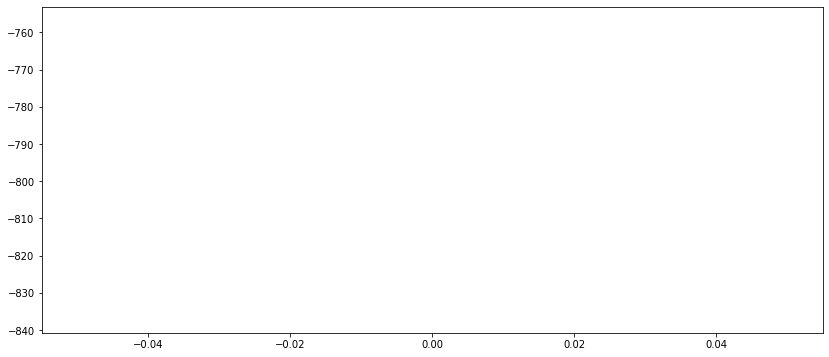

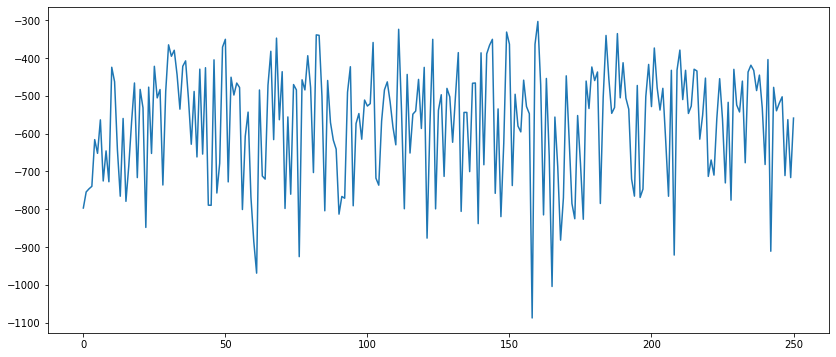

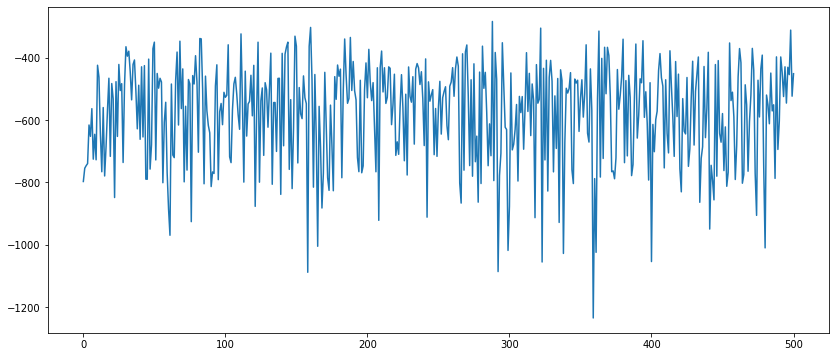

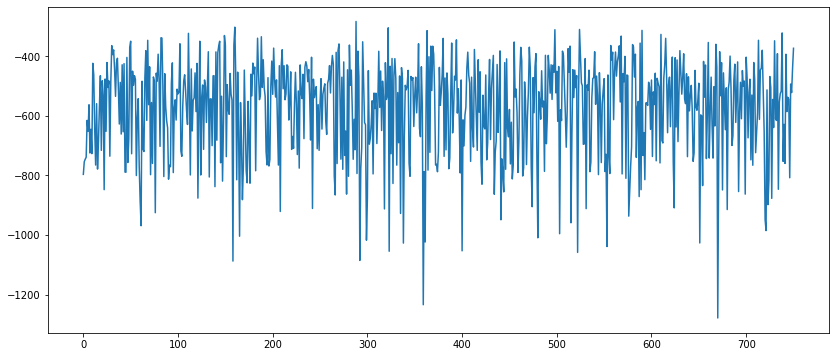

In [158]:
new_rewards = run_agent_in_env(env, agent, 1000, learning=False, plot=True, plot_interval=250)

In [159]:
print(np.min(new_rewards))
print(np.mean(new_rewards))
print(np.max(new_rewards))

-1278.6553716744602
-582.372510907128
-284.1020044571758
